# 🧬 酵母四分体菌落图像分析教程
## Colony Image Analysis Tutorial for Yeast Tetrad Dissection

---

### 📋 教程目标

本教程将带你从零开始学习如何：
1. **图像预处理**: 灰度转换、高斯模糊、阈值分割
2. **菌落检测**: 形态学操作、分水岭分割、质心提取
3. **图像对齐**: 匈牙利算法匹配、RANSAC 仿射变换
4. **基因型判断**: 网格拟合、信号测量、SNR 分析

### 🎯 应用场景

- **Tetrad 平板 (基准图)**: 四分体解剖后的黑底平板，每个 tetrad 有 4 个孢子
- **HYG 平板 (筛选图)**: 转印后的潮霉素筛选平板
  - **Non-Essential Gene**: DEL 有 HYG 抗性能生长，WT 不长
  - **Essential Gene**: DEL 致死不长，WT 无抗性也不长

### 📚 教程结构

| 章节 | 内容 | 重点概念 |
|------|------|----------|
| 1 | 环境配置与库导入 | matplotlib, OpenCV, scikit-image |
| 2 | 图像读取与显示 | RGB vs BGR, dtype |
| 3 | 灰度转换 | 通道选择策略 |
| 4 | 高斯模糊 | σ 参数调优 |
| 5 | Otsu 阈值分割 | 自动阈值原理 |
| 6 | 形态学操作 | 开运算、闭运算 |
| 7 | 分水岭分割 | 融合菌落分离 |
| 8 | 区域属性提取 | regionprops, centroid |
| 9 | 图像对齐 | 仿射变换, RANSAC |
| 10 | 网格拟合 | PCA 旋转校正 |
| 11 | 信号测量与基因型判断 | SNR, 背景建模 |

---

> **💡 提示**: 本教程中所有代码均可直接运行，请按顺序执行每个 Cell。

---
## 第一章：环境配置与库导入

在开始图像分析之前，我们需要：
1. **设置全局字体** — 确保图表使用 Arial 字体
2. **导入必要的库** — 包括图像处理、数值计算和可视化工具

### 依赖库说明

| 库名 | 用途 |
|------|------|
| **NumPy** | 数值计算，数组操作 |
| **Matplotlib** | 图像可视化，绑制图表 |
| **OpenCV (cv2)** | 图像对齐，仿射变换 |
| **scikit-image** | 图像分割，特征提取 |
| **SciPy** | 距离计算，优化算法 |

In [1]:
# ============================================================
# 1.1 Global Font Settings - Use Arial Font
# ============================================================

import matplotlib
import matplotlib.pyplot as plt

# Set Matplotlib global font to Arial
# If Arial is not available, it will fallback to DejaVu Sans
plt.rcParams.update({
    'axes.unicode_minus': False,  # Correctly display minus sign
    'figure.dpi': 100,            # Image resolution
    'axes.titlesize': 12,         # Title font size
    'axes.labelsize': 10,         # Axis label font size
})

In [2]:
# ============================================================
# 1.2 Import Required Libraries
# ============================================================

import numpy as np
from matplotlib.patches import Circle

# OpenCV - Image alignment and affine transformation
import cv2

# scikit-image - Image processing toolkit
from skimage import io, filters, measure, morphology
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import gaussian, threshold_otsu

# scipy - Distance calculation and optimization
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment, minimize
from scipy import ndimage

# Verify imports
print("✅ All libraries imported successfully!")
print(f"   OpenCV version: {cv2.__version__}")
print(f"   NumPy version: {np.__version__}")

✅ All libraries imported successfully!
   OpenCV version: 4.12.0
   NumPy version: 2.2.6


---
## 第二章：图像读取与基本操作

### 2.1 图像读取函数对比

Python 中常用的图像读取方式有两种，它们在颜色通道顺序上有重要区别：

| 特性 | `skimage.io.imread` | `cv2.imread` |
|------|---------------------|--------------|
| 颜色顺序 | **RGB** (红-绿-蓝) | **BGR** (蓝-绿-红) |
| 数据类型 | 取决于原图 | 默认 uint8 |
| 与 Matplotlib 兼容性 | ✅ 直接兼容 | ❌ 需要转换 |

> **📌 本教程使用 `skimage.io.imread`**，因为它返回 RGB 格式，可直接用于 Matplotlib 显示。

### 2.2 实验数据说明

我们使用两张实验图像：
- **Tetrad 平板**: 四分体解剖后的基准图（黑色背景）
- **HYG 平板**: 潮霉素筛选后的转印图（绿色背景）

✅ Images loaded successfully!

📊 Image info:
   Tetrad plate: (294, 735, 3) | dtype: uint8
   HYG plate:    (294, 735, 3) | dtype: uint8


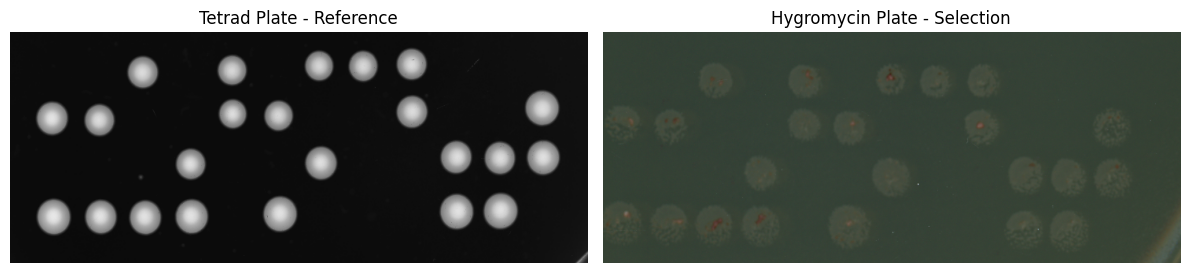

In [3]:
# ============================================================
# 2.1 Define Image Paths and Read
# ============================================================

# 示例图像路径 (Non-Essential Gene 案例)
TETRAD_PATH = "/hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/6d/242_tyw3_6d_#1_202510.cropped.png"
HYG_PATH = "/hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/replica/242_tyw3_HYG_#1_202510.cropped.png"

tetrad_plate = io.imread(TETRAD_PATH)
hyg_plate = io.imread(HYG_PATH)

print("✅ Images loaded successfully!")
print(f"\n📊 Image info:")
print(f"   Tetrad plate: {tetrad_plate.shape} | dtype: {tetrad_plate.dtype}")
print(f"   HYG plate:    {hyg_plate.shape} | dtype: {hyg_plate.dtype}")

# Display original images
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(tetrad_plate)
axes[0].set_title('Tetrad Plate - Reference')
axes[0].axis('off')

axes[1].imshow(hyg_plate)
axes[1].set_title('Hygromycin Plate - Selection')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Save copies for later use
tetrad_original = tetrad_plate.copy()
hyg_original = hyg_plate.copy()
sample_plate = tetrad_plate.copy()

---
## 第三章：灰度转换

### 3.1 为什么需要灰度图？

图像分割算法通常需要**单通道（灰度）输入**，而彩色图像有 3 个通道 (RGB)。

### 3.2 常用的灰度转换方法

| 方法 | 公式 | 适用场景 |
|------|------|----------|
| **取平均值** | $\text{gray} = \frac{R + G + B}{3}$ | 一般场景 |
| **加权平均** | $\text{gray} = 0.299R + 0.587G + 0.114B$ | 模拟人眼感知 |
| **取单通道** | $\text{gray} = R$ 或 $G$ 或 $B$ | 特定颜色背景 |

### 3.3 针对不同平板的策略

- **Tetrad 平板 (黑底)**: 使用 `np.mean(img, axis=2)` 取平均值
- **HYG 平板 (绿底)**: 使用 `img[:, :, 0]` 取红色通道
  - 原因：绿色背景在红色通道中呈现为**暗色**，而白色菌落保持**亮色**，对比度更高

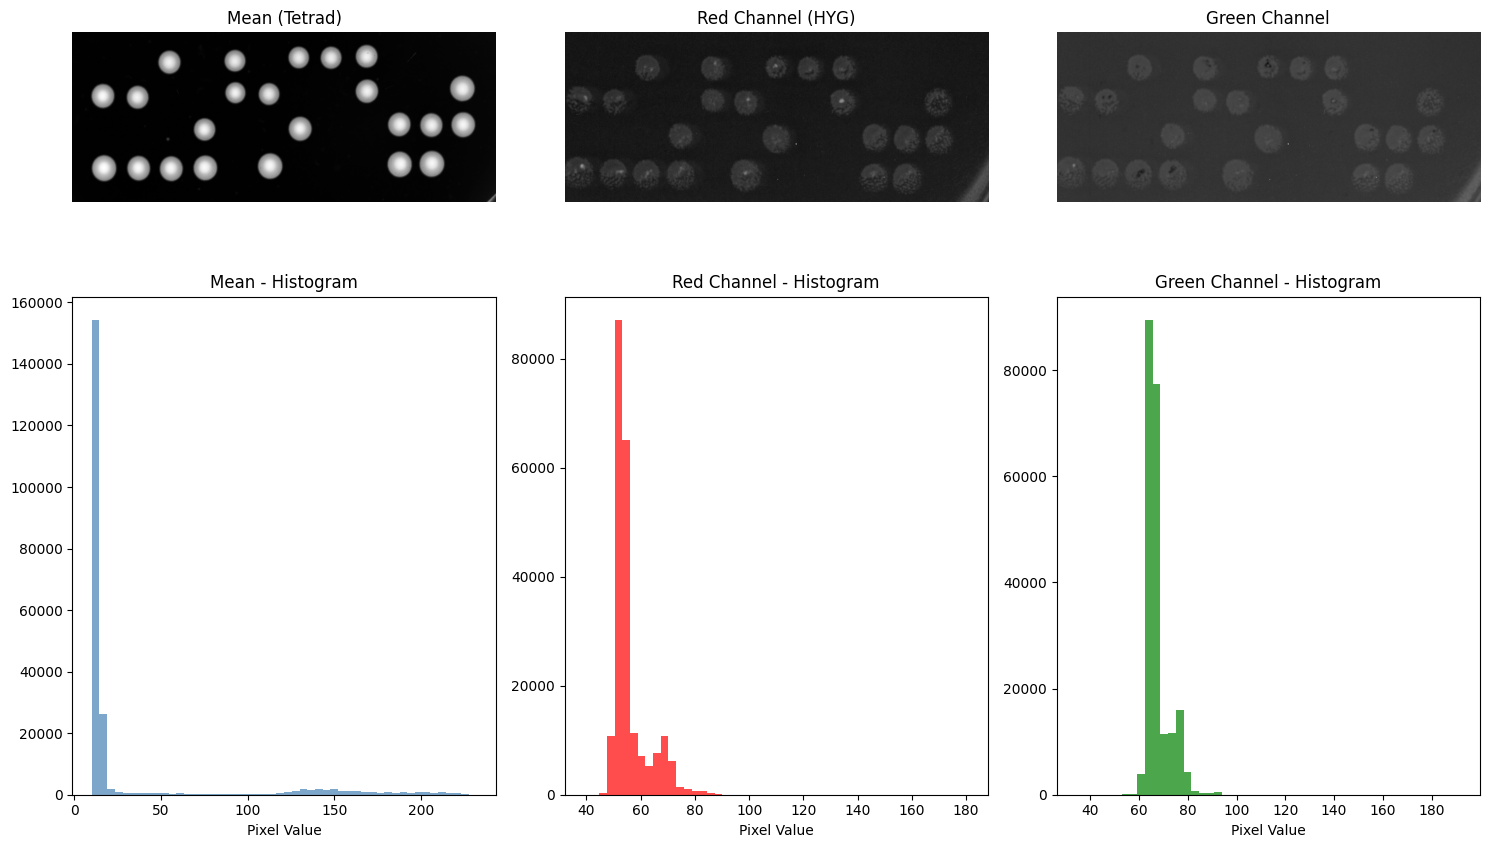

📝 Summary:
   Tetrad plate: np.mean() - Extract average brightness of all channels
   HYG plate:    Red channel - White colonies have high red values on green background



In [4]:
# ============================================================
# 3.1 Grayscale Conversion Methods Comparison
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Method 1: Mean - Recommended for Tetrad
gray_mean = np.mean(tetrad_plate, axis=2)
axes[0, 0].imshow(gray_mean, cmap='gray')
axes[0, 0].set_title('Mean (Tetrad)')
axes[0, 0].axis('off')

# Method 2: Red channel - Recommended for HYG
gray_red = hyg_plate[:, :, 0].astype(float)
axes[0, 1].imshow(gray_red, cmap='gray')
axes[0, 1].set_title('Red Channel (HYG)')
axes[0, 1].axis('off')

# Method 3: Green channel
gray_green = hyg_plate[:, :, 1].astype(float)
axes[0, 2].imshow(gray_green, cmap='gray')
axes[0, 2].set_title('Green Channel')
axes[0, 2].axis('off')

# Histogram comparison
axes[1, 0].hist(gray_mean.ravel(), bins=50, color='steelblue', alpha=0.7)
axes[1, 0].set_title('Mean - Histogram')
axes[1, 0].set_xlabel('Pixel Value')

axes[1, 1].hist(gray_red.ravel(), bins=50, color='red', alpha=0.7)
axes[1, 1].set_title('Red Channel - Histogram')
axes[1, 1].set_xlabel('Pixel Value')

axes[1, 2].hist(gray_green.ravel(), bins=50, color='green', alpha=0.7)
axes[1, 2].set_title('Green Channel - Histogram')
axes[1, 2].set_xlabel('Pixel Value')

plt.tight_layout()
plt.show()

print("""📝 Summary:
   Tetrad plate: np.mean() - Extract average brightness of all channels
   HYG plate:    Red channel - White colonies have high red values on green background
""")

---
## 第四章：高斯模糊

### 4.1 为什么需要模糊？

高斯模糊是一种**低通滤波器**，主要作用：
- 🔇 **减少噪声** — 平滑图像中的随机噪点
- 🌫️ **去除细节** — 忽略不重要的纹理
- 📈 **改善分割** — 使二值化结果更加平滑

### 4.2 高斯核公式

$$G(x,y) = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)$$

其中 $\sigma$ (sigma) 是**标准差**，控制模糊程度：

| σ 值 | 效果 | 适用场景 |
|------|------|----------|
| 0.5 - 1.0 | 轻微模糊 | HYG 平板，保留细节 |
| 1.0 - 2.0 | 中等模糊 | Tetrad 平板 |
| 2.0+ | 强模糊 | 噪声严重的图像 |

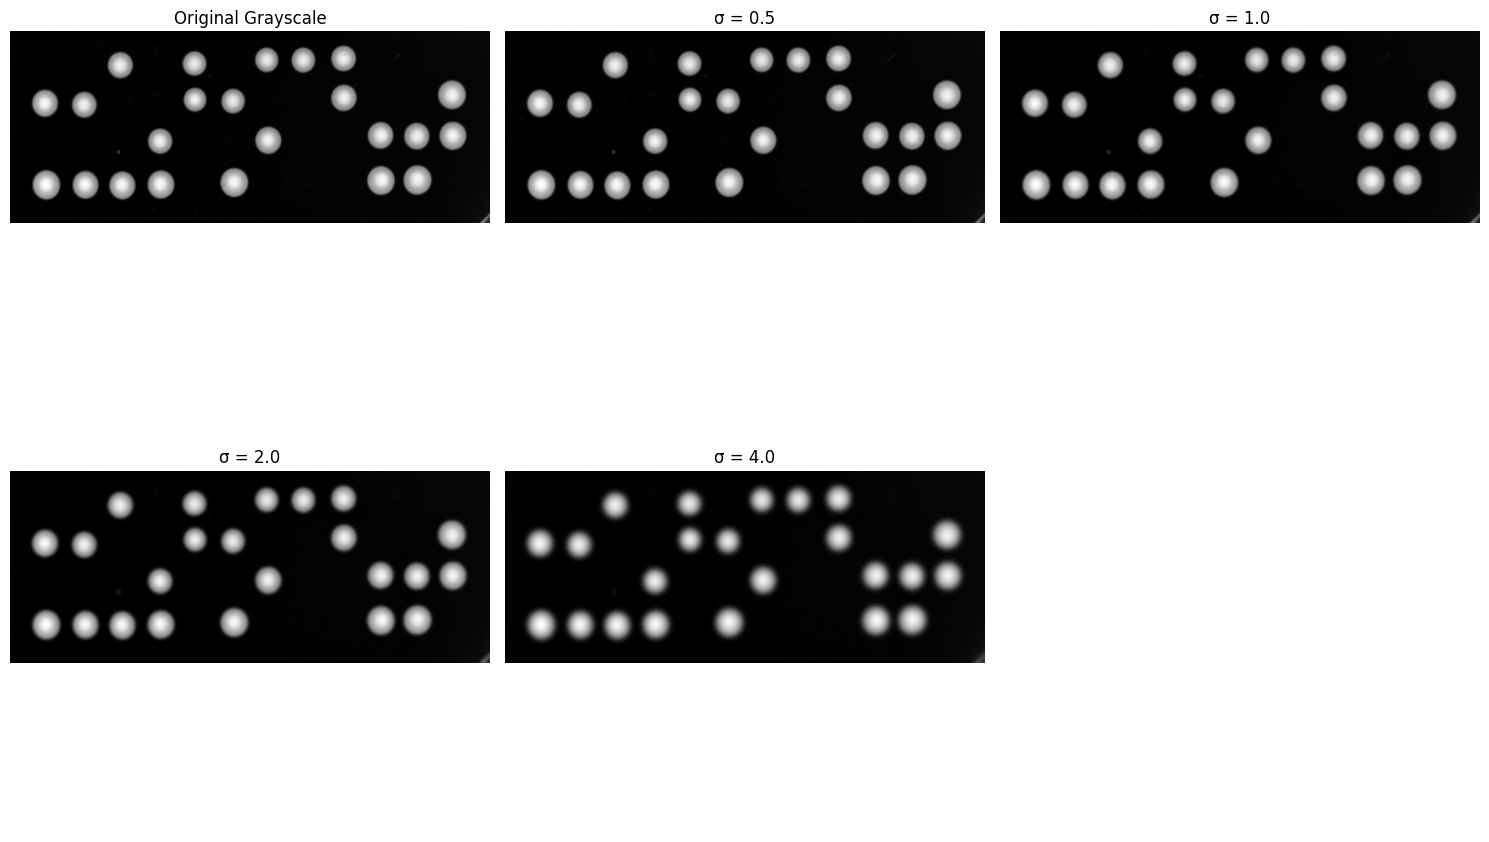

📝 Recommended parameters:
   Tetrad plate: sigma = 1.0 ~ 2.0 (larger colonies)
   HYG plate:    sigma = 0.5 ~ 1.0 (smaller colonies)



In [5]:
# ============================================================
# 4.1 Gaussian Blur Effect Comparison
# ============================================================

# Using grayscale of Tetrad plate
gray = np.mean(tetrad_plate, axis=2)

# Test different sigma values
sigmas = [0.5, 1.0, 2.0, 4.0]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original image
axes[0, 0].imshow(gray, cmap='gray')
axes[0, 0].set_title('Original Grayscale')
axes[0, 0].axis('off')

# Different sigma values
for i, sigma in enumerate(sigmas):
    blurred = gaussian(gray, sigma=sigma, preserve_range=True)
    ax = axes[(i+1)//3, (i+1)%3]
    ax.imshow(blurred, cmap='gray')
    ax.set_title(f'σ = {sigma}')
    ax.axis('off')

axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

print("""📝 Recommended parameters:
   Tetrad plate: sigma = 1.0 ~ 2.0 (larger colonies)
   HYG plate:    sigma = 0.5 ~ 1.0 (smaller colonies)
""")

---
## 第五章：阈值分割 (Otsu 方法)

### 5.1 什么是阈值分割？

将灰度图转换为**二值图** (Binary Image):
- 像素值 > 阈值 → **白色** (前景/菌落)
- 像素值 ≤ 阈值 → **黑色** (背景)

### 5.2 Otsu 方法原理

Otsu 方法**自动计算**最佳阈值，通过最大化**类间方差**：

$$\sigma_B^2(t) = \omega_0(t) \cdot \omega_1(t) \cdot [\mu_0(t) - \mu_1(t)]^2$$

其中：
- $\omega_0, \omega_1$ 是两类的像素比例
- $\mu_0, \mu_1$ 是两类的平均灰度值

### 5.3 优点与限制

✅ **优点**: 自动计算，无需手动调参  
⚠️ **限制**: 对双峰直方图效果最好；单峰图像可能失效

✅ Otsu automatic threshold: 84.9


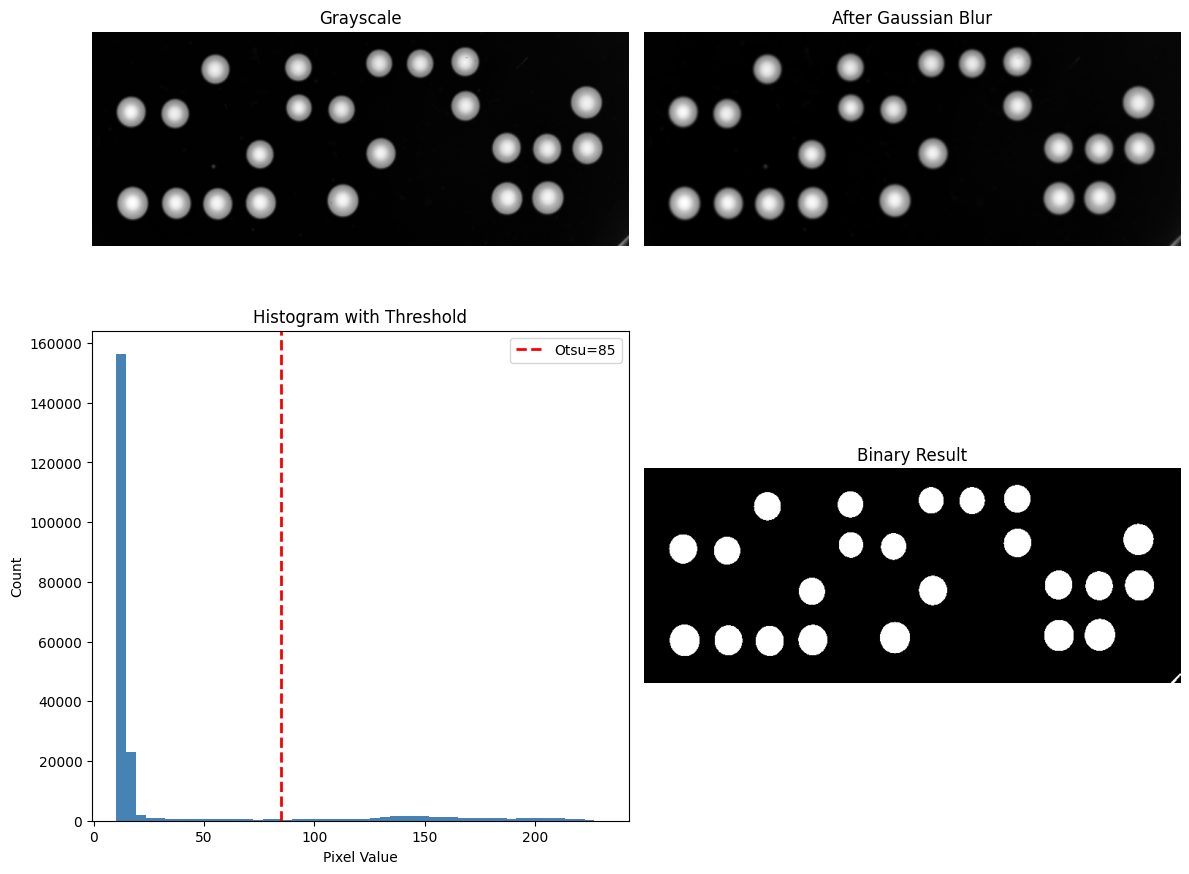

In [6]:
# ============================================================
# 5.1 Otsu Threshold Segmentation Demonstration
# ============================================================

# Preprocessing: Grayscale + Gaussian blur
gray = np.mean(tetrad_plate, axis=2)
blurred = gaussian(gray, sigma=1.0, preserve_range=True)

# Otsu threshold calculation
threshold = threshold_otsu(blurred)
binary_mask = blurred > threshold

print(f"✅ Otsu automatic threshold: {threshold:.1f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(gray, cmap='gray')
axes[0, 0].set_title('Grayscale')
axes[0, 0].axis('off')

axes[0, 1].imshow(blurred, cmap='gray')
axes[0, 1].set_title('After Gaussian Blur')
axes[0, 1].axis('off')

axes[1, 0].hist(blurred.ravel(), bins=50, color='steelblue')
axes[1, 0].axvline(threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'Otsu={threshold:.0f}')
axes[1, 0].set_xlabel('Pixel Value')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Histogram with Threshold')
axes[1, 0].legend()

axes[1, 1].imshow(binary_mask, cmap='gray')
axes[1, 1].set_title('Binary Result')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

---
## 第六章：形态学操作

### 6.1 为什么需要形态学操作？

二值化后的图像可能存在：
- 🔴 **噪点** — 小的白色斑点 (假阳性)
- ⚫ **孔洞** — 菌落内部的黑色空洞

形态学操作可以有效清理这些问题。

### 6.2 基本操作

| 操作 | 英文名 | 效果 | 用途 |
|------|--------|------|------|
| **腐蚀** | Erosion | 缩小白色区域 | 去除边缘 |
| **膨胀** | Dilation | 扩大白色区域 | 填充空隙 |
| **开运算** | Opening | 腐蚀 → 膨胀 | 🎯 **去除噪点** |
| **闭运算** | Closing | 膨胀 → 腐蚀 | 填充孔洞 |

### 6.3 结构元素 (Structuring Element)

定义操作的"形状"和"强度"：
- `morphology.disk(r)` — 圆形，半径 r
- `morphology.square(n)` — 方形，边长 n

> **💡 推荐**: 使用 `disk(3)` 进行开运算，可有效去除噪点同时保持菌落形状。

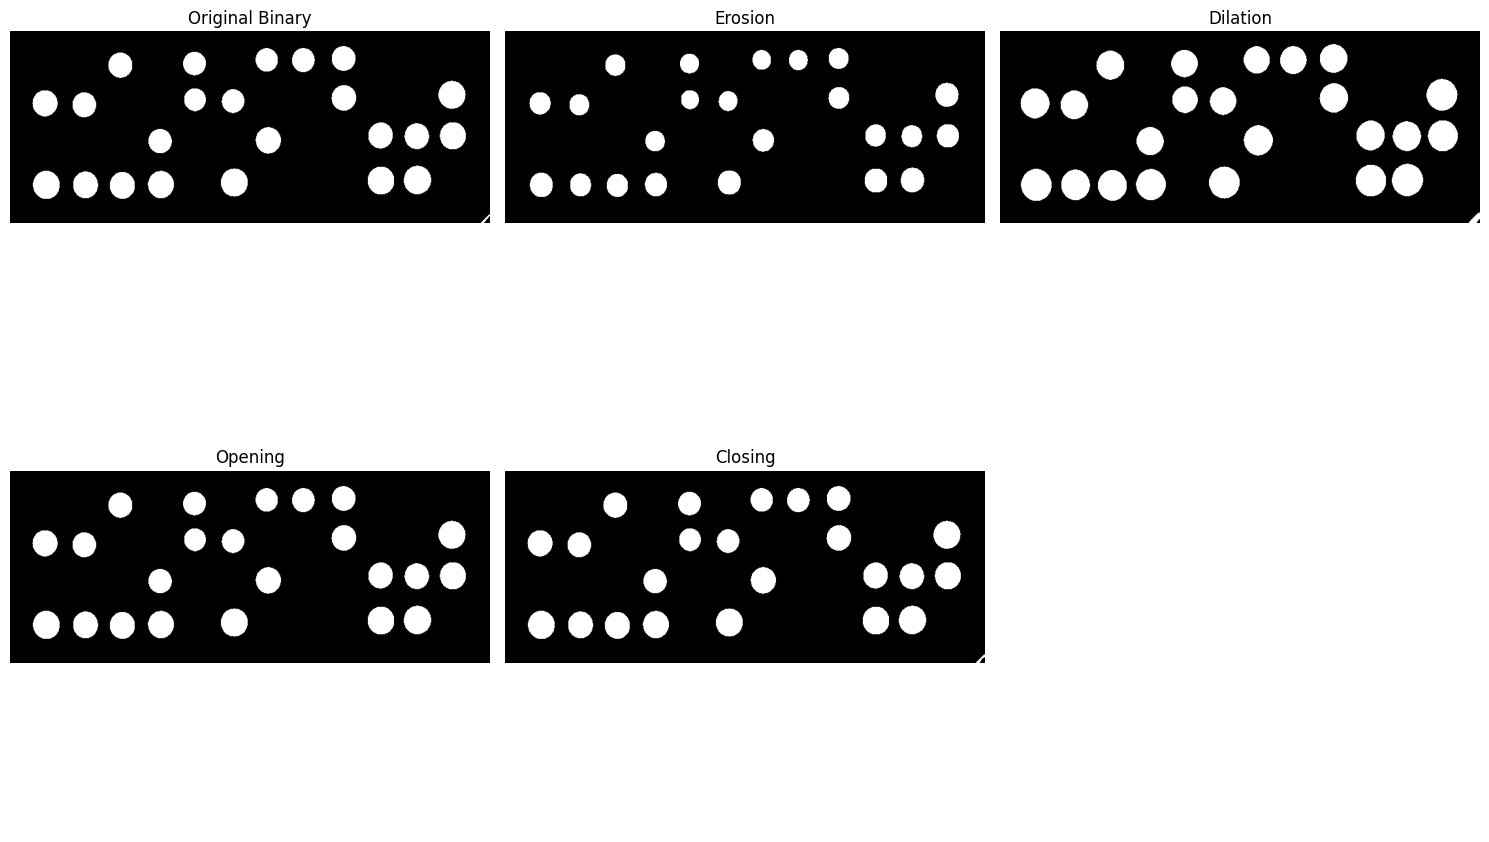

📝 Applications in colony detection:
   Opening: Remove small noise while preserving colony shape ← Recommended!
   Closing: Fill internal holes in colonies



In [7]:
# ============================================================
# 6.1 Morphological Operations Effect Comparison
# ============================================================

# Create structuring element
selem = morphology.disk(3)  # Disk with radius 3

# Apply various morphological operations
eroded = morphology.binary_erosion(binary_mask, selem)
dilated = morphology.binary_dilation(binary_mask, selem)
opened = morphology.binary_opening(binary_mask, selem)
closed = morphology.binary_closing(binary_mask, selem)

operations = [
    (binary_mask, 'Original Binary'),
    (eroded, 'Erosion'),
    (dilated, 'Dilation'),
    (opened, 'Opening'),
    (closed, 'Closing')
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (img, title) in enumerate(operations):
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(title)
    axes[idx].axis('off')

axes[5].axis('off')
plt.tight_layout()
plt.show()

print("""📝 Applications in colony detection:
   Opening: Remove small noise while preserving colony shape ← Recommended!
   Closing: Fill internal holes in colonies
""")

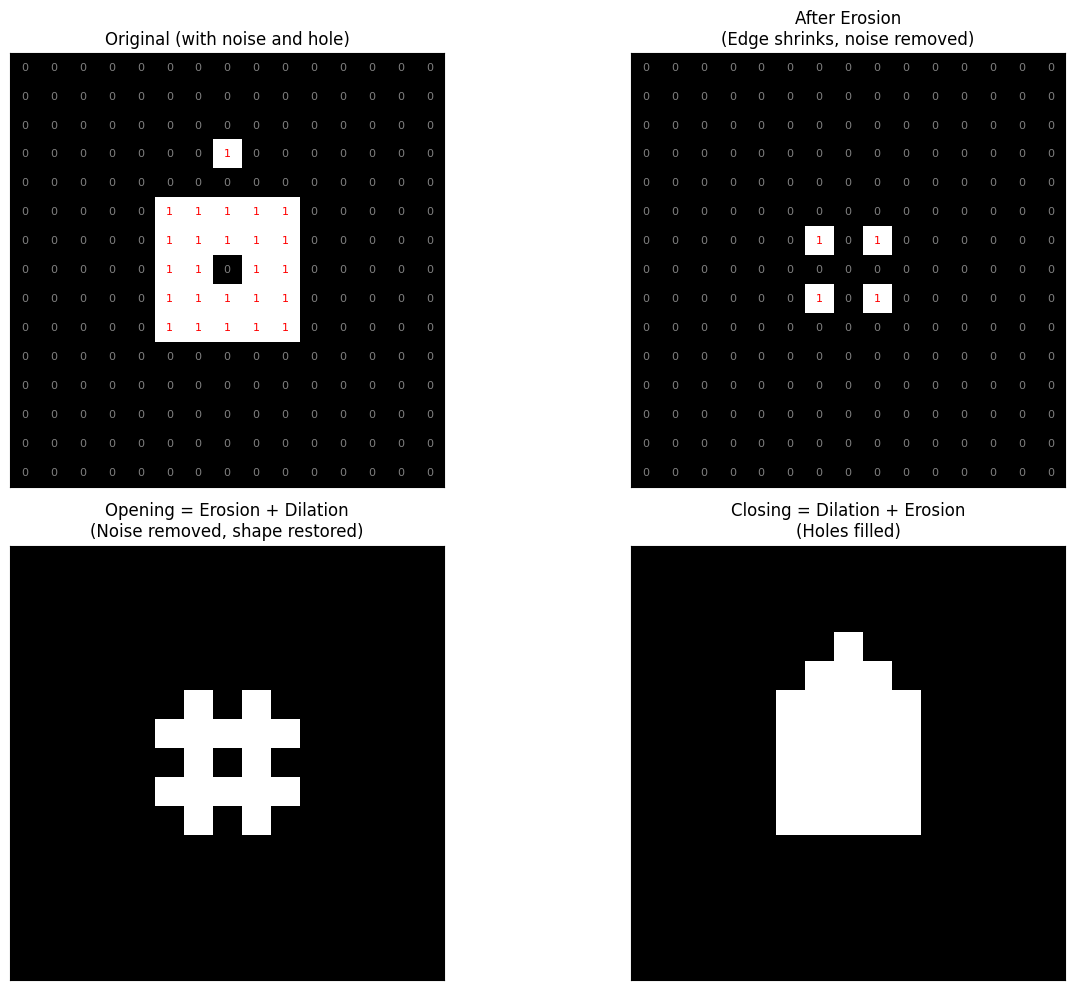

In [8]:
# ============================================================
# 6.2 Morphological Operations Principle Illustration
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Create demonstration image
demo_size = 15
demo_img = np.zeros((demo_size, demo_size), dtype=np.uint8)
demo_img[5:10, 5:10] = 1  # Main region
demo_img[3, 7] = 1  # Isolated noise point
demo_img[7, 7] = 0  # Internal hole
selem_small = morphology.disk(1)

# Erosion and Dilation basic principle
axes[0, 0].imshow(demo_img, cmap='gray')
axes[0, 0].set_title('Original (with noise and hole)')
for i in range(demo_size):
    for j in range(demo_size):
        axes[0, 0].text(j, i, int(demo_img[i, j]), ha='center', va='center', 
                        fontsize=8, color='red' if demo_img[i, j] else 'gray')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

demo_eroded = morphology.binary_erosion(demo_img, selem_small)
axes[0, 1].imshow(demo_eroded, cmap='gray')
axes[0, 1].set_title('After Erosion\n(Edge shrinks, noise removed)')
for i in range(demo_size):
    for j in range(demo_size):
        axes[0, 1].text(j, i, int(demo_eroded[i, j]), ha='center', va='center', 
                        fontsize=8, color='red' if demo_eroded[i, j] else 'gray')
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

# Opening removes noise
demo_opened = morphology.binary_opening(demo_img, selem_small)
axes[1, 0].imshow(demo_opened, cmap='gray')
axes[1, 0].set_title('Opening = Erosion + Dilation\n(Noise removed, shape restored)')
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])

# Closing fills holes
demo_with_hole = demo_img.copy()
demo_with_hole[7, 7] = 0
demo_closed = morphology.binary_closing(demo_with_hole, selem_small)
axes[1, 1].imshow(demo_closed, cmap='gray')
axes[1, 1].set_title('Closing = Dilation + Erosion\n(Holes filled)')
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])

plt.tight_layout()
plt.show()

HYG plate Otsu threshold: 61.0


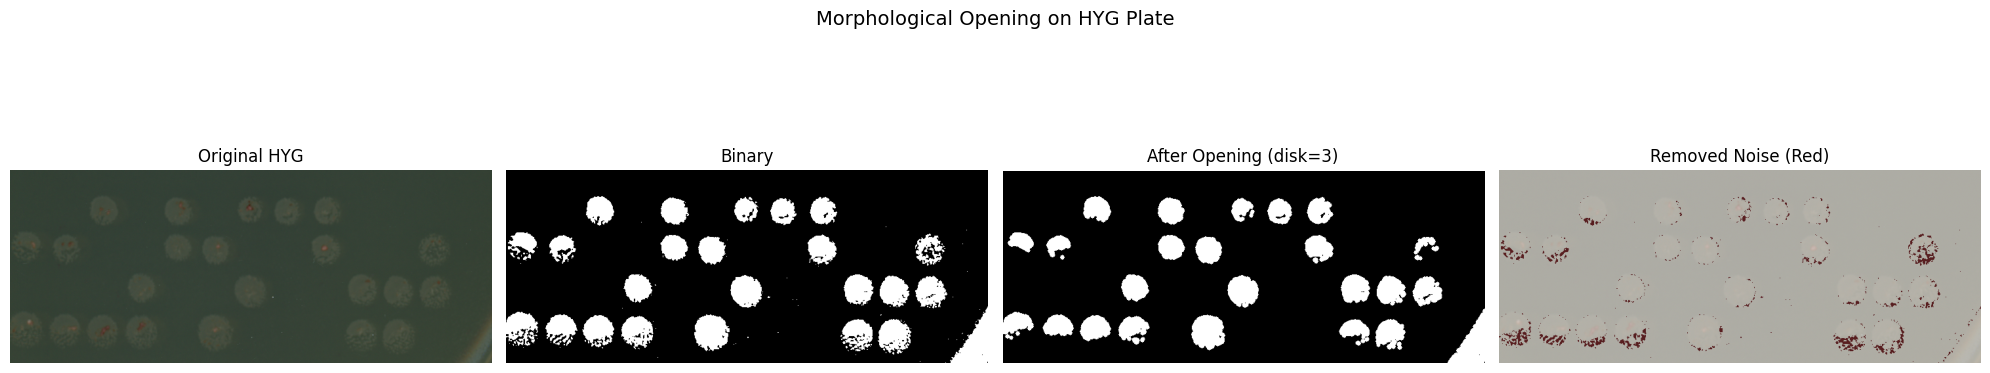


📊 Statistics:
   Original white pixels: 35,344
   After cleaning: 31,156
   Removed noise: 4,188 (11.8%)


In [9]:
# ============================================================
# 6.3 Morphological Opening Effect on Real HYG Image
# ============================================================

# HYG plate processing: Use red channel
gray_hyg = hyg_plate[:, :, 0].astype(float)
blurred_hyg = gaussian(gray_hyg, sigma=0.5, preserve_range=True)
thresh_hyg = threshold_otsu(blurred_hyg)
binary_hyg = blurred_hyg > thresh_hyg

print(f"HYG plate Otsu threshold: {thresh_hyg:.1f}")

# Apply morphological operations
opened_hyg_3 = morphology.binary_opening(binary_hyg, morphology.disk(3))

# Visualization: Overlay comparison
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(hyg_plate)
axes[0].set_title('Original HYG')
axes[0].axis('off')

axes[1].imshow(binary_hyg, cmap='gray')
axes[1].set_title('Binary')
axes[1].axis('off')

axes[2].imshow(opened_hyg_3, cmap='gray')
axes[2].set_title('After Opening (disk=3)')
axes[2].axis('off')

# Difference comparison: Removed noise
diff = binary_hyg.astype(int) - opened_hyg_3.astype(int)
axes[3].imshow(hyg_plate)
axes[3].imshow(diff == 1, alpha=0.6, cmap='Reds')
axes[3].set_title('Removed Noise (Red)')
axes[3].axis('off')

plt.suptitle('Morphological Opening on HYG Plate', fontsize=14)
plt.tight_layout()
plt.show()

# Statistics
removed_pixels = np.sum(binary_hyg) - np.sum(opened_hyg_3)
print(f"\n📊 Statistics:")
print(f"   Original white pixels: {np.sum(binary_hyg):,}")
print(f"   After cleaning: {np.sum(opened_hyg_3):,}")
print(f"   Removed noise: {removed_pixels:,} ({removed_pixels/np.sum(binary_hyg)*100:.1f}%)")

---
## 第七章：分水岭分割

### 7.1 问题：融合的菌落

当两个菌落靠得很近时，二值化会把它们**合并成一个区域**，导致无法分别计数。

### 7.2 分水岭算法原理

想象图像是一个**地形图**：
1. 将灰度值（距离变换后）视为「海拔高度」
2. 从局部最低点（背景边缘）开始「注水」
3. 水位上升直到不同流域相遇
4. 相遇处形成「分水岭」—— 即菌落边界

### 7.3 实现步骤

```python
# Step 1: 距离变换 - 计算每个前景像素到最近背景的距离
distance_map = ndimage.distance_transform_edt(binary_mask)

# Step 2: 找局部最大值作为种子点
coords = peak_local_max(distance_map, min_distance=20)

# Step 3: 应用分水岭分割
labels = watershed(-distance_map, markers, mask=binary_mask)
```

✅ Found 2 local maxima (colony centers)


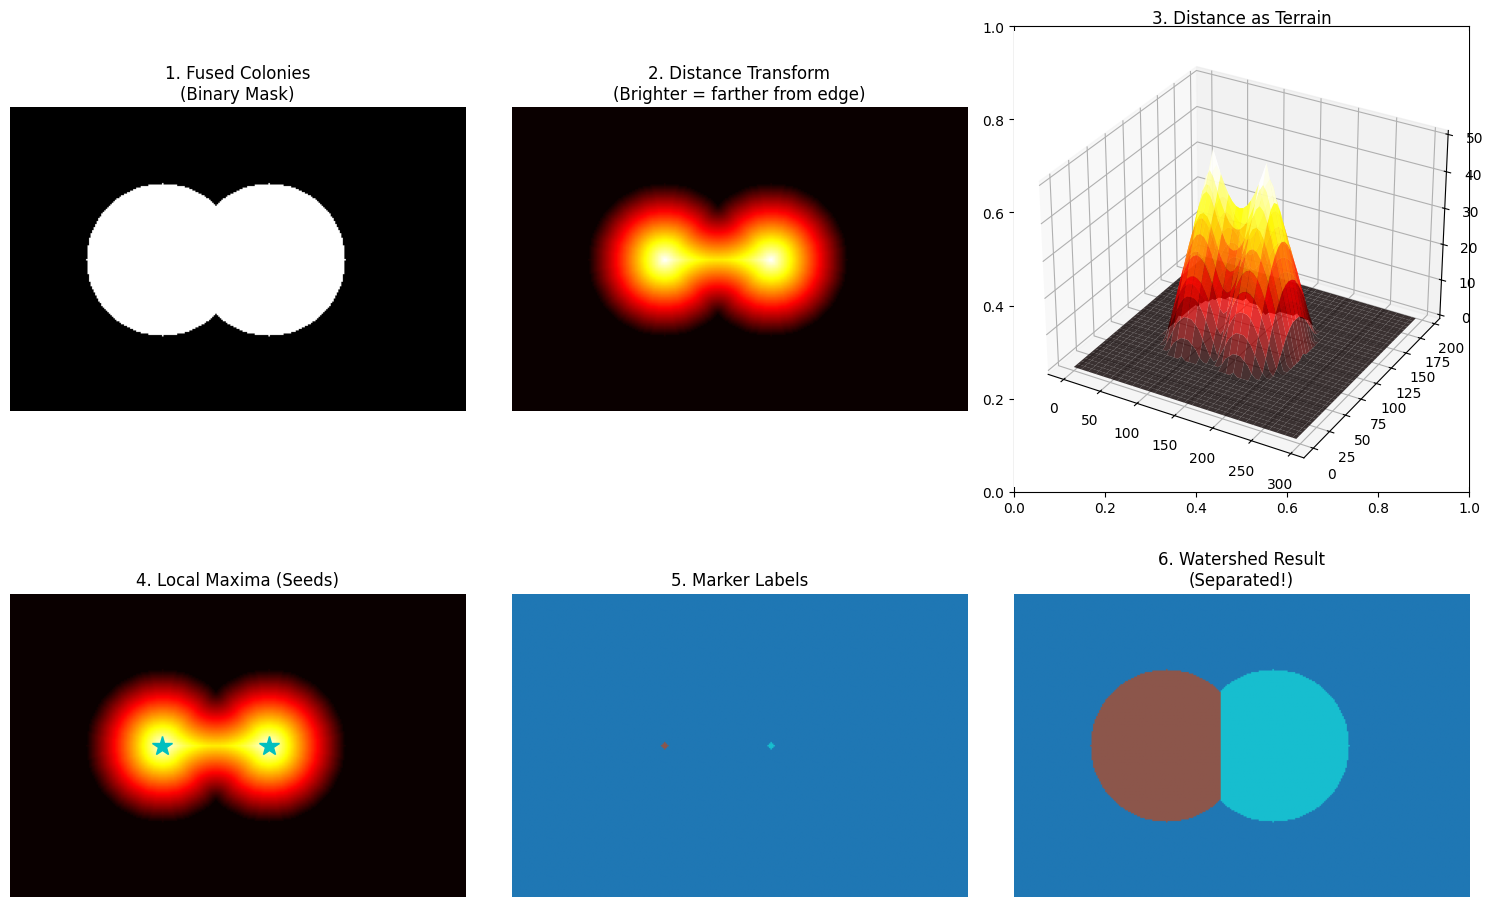


📝 Key parameters:
   min_distance: Minimum distance between two seed points
   • Tetrad plate: min_distance=20
   • HYG plate: min_distance=5 (smaller colonies)



In [10]:
# ============================================================
# 7. Watershed Algorithm Demonstration
# ============================================================

# Create two fused circles (simulating fused colonies)
def create_fused_colonies():
    img = np.zeros((200, 300), dtype=np.uint8)
    cv2.circle(img, (100, 100), 50, 255, -1)
    cv2.circle(img, (170, 100), 50, 255, -1)
    return img > 0

fused_mask = create_fused_colonies()

# Step 1: Distance transform
distance_map = ndimage.distance_transform_edt(fused_mask)

# Step 2: Find local maxima
coords = peak_local_max(distance_map, min_distance=20, labels=fused_mask.astype(int))
print(f"✅ Found {len(coords)} local maxima (colony centers)")

# Create markers
markers = np.zeros(distance_map.shape, dtype=int)
markers[tuple(coords.T)] = np.arange(1, len(coords) + 1)
markers = morphology.binary_dilation(markers > 0, morphology.disk(2))
markers = measure.label(markers)

# Step 3: Watershed segmentation
ws_labels = watershed(-distance_map, markers, mask=fused_mask)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(fused_mask, cmap='gray')
axes[0, 0].set_title('1. Fused Colonies\n(Binary Mask)')
axes[0, 0].axis('off')

axes[0, 1].imshow(distance_map, cmap='hot')
axes[0, 1].set_title('2. Distance Transform\n(Brighter = farther from edge)')
axes[0, 1].axis('off')

# 3D visualization
from mpl_toolkits.mplot3d import Axes3D
ax3d = fig.add_subplot(2, 3, 3, projection='3d')
X, Y = np.meshgrid(range(distance_map.shape[1]), range(distance_map.shape[0]))
ax3d.plot_surface(X[::5, ::5], Y[::5, ::5], distance_map[::5, ::5], cmap='hot', alpha=0.8)
ax3d.set_title('3. Distance as Terrain')

axes[1, 0].imshow(distance_map, cmap='hot')
for i, (y, x) in enumerate(coords):
    axes[1, 0].plot(x, y, 'c*', markersize=15)
axes[1, 0].set_title('4. Local Maxima (Seeds)')
axes[1, 0].axis('off')

axes[1, 1].imshow(markers, cmap='tab10')
axes[1, 1].set_title('5. Marker Labels')
axes[1, 1].axis('off')

axes[1, 2].imshow(ws_labels, cmap='tab10')
axes[1, 2].set_title('6. Watershed Result\n(Separated!)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("""
📝 Key parameters:
   min_distance: Minimum distance between two seed points
   • Tetrad plate: min_distance=20
   • HYG plate: min_distance=5 (smaller colonies)
""")

---
## 第八章：区域属性与质心提取

### 8.1 连通区域标记

`measure.label()` 将二值图中的**连通区域**标记为不同整数：
- 背景 = 0
- 区域1 = 1, 区域2 = 2, ...

### 8.2 区域属性 (regionprops)

`measure.regionprops()` 计算每个区域的属性：

| 属性 | 说明 | 用途 |
|------|------|------|
| `area` | 面积 (像素数) | 过滤噪点 |
| `centroid` | 质心坐标 (y, x) | 定位菌落 |
| `bbox` | 边界框 | 裁剪区域 |
| `eccentricity` | 离心率 | 判断形状 |

> ⚠️ **注意**: `centroid` 返回的是 `(row, col)` = `(y, x)`，与图像坐标 `(x, y)` 相反！

In [11]:
# ============================================================
# 8. Region Properties Extraction
# ============================================================

# Using Tetrad plate
cleaned_mask = morphology.binary_opening(binary_mask, morphology.disk(3))

# Label connected regions
label_img = measure.label(cleaned_mask)
print(f"✅ Detected {label_img.max()} connected regions")

# Calculate region properties
props = measure.regionprops(label_img)

# Extract centroids (filter regions with area > 10)
min_area = 10
centroids = []
areas = []

for prop in props:
    if prop.area > min_area:
        y, x = prop.centroid  # Note: (row, col) = (y, x)
        centroids.append((x, y))
        areas.append(prop.area)

print(f"   After filtering: {len(centroids)} colonies retained (area > {min_area})")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Label map
axes[0].imshow(label_img, cmap='nipy_spectral')
axes[0].set_title('Labeled Regions\n(Each color = one colony)')
axes[0].axis('off')

# Centroid markers
axes[1].imshow(tetrad_plate)
for (x, y) in centroids:
    axes[1].plot(x, y, 'r+', markersize=10, markeredgewidth=2)
axes[1].set_title(f'Detected Centroids\n({len(centroids)} colonies)')
axes[1].axis('off')

# Area distribution
if areas:
    axes[2].hist(areas, bins=20, color='steelblue', edgecolor='white')
    axes[2].axvline(np.median(areas), color='red', linestyle='--', 
                    label=f'Median: {np.median(areas):.0f}')
    axes[2].set_xlabel('Area (pixels)')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Colony Size Distribution')
    axes[2].legend()

plt.tight_layout()
plt.show()

✅ Detected 23 connected regions
   After filtering: 23 colonies retained (area > 10)


---
## 第九章：图像对齐

### 9.1 为什么需要对齐？

转印过程中，两张图片可能存在：
- 📐 **平移** (Translation) — 位置偏移
- 🔄 **旋转** (Rotation) — 角度偏差
- 📏 **缩放** (Scale) — 大小差异

### 9.2 仿射变换

仿射变换可以同时处理平移、旋转和缩放：

$$\begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} a & b \\ c & d \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} t_x \\ t_y \end{bmatrix}$$

OpenCV 使用 2×3 矩阵: $M = \begin{bmatrix} a & b & t_x \\ c & d & t_y \end{bmatrix}$

### 9.3 对齐流程

1. **检测菌落** — 在两张图上分别检测质心
2. **匈牙利匹配** — 找到最优的点对匹配
3. **RANSAC 估计** — 鲁棒地计算变换矩阵
4. **应用变换** — `cv2.warpAffine()` 对齐图像

✅ Tetrad: 23 colonies
   HYG:    27 colonies
   Matched: 23 pairs

📊 Estimated Transform:
   Scale: 1.0021
   Rotation: -1.96°
   Translation: (23.6, -3.5) px


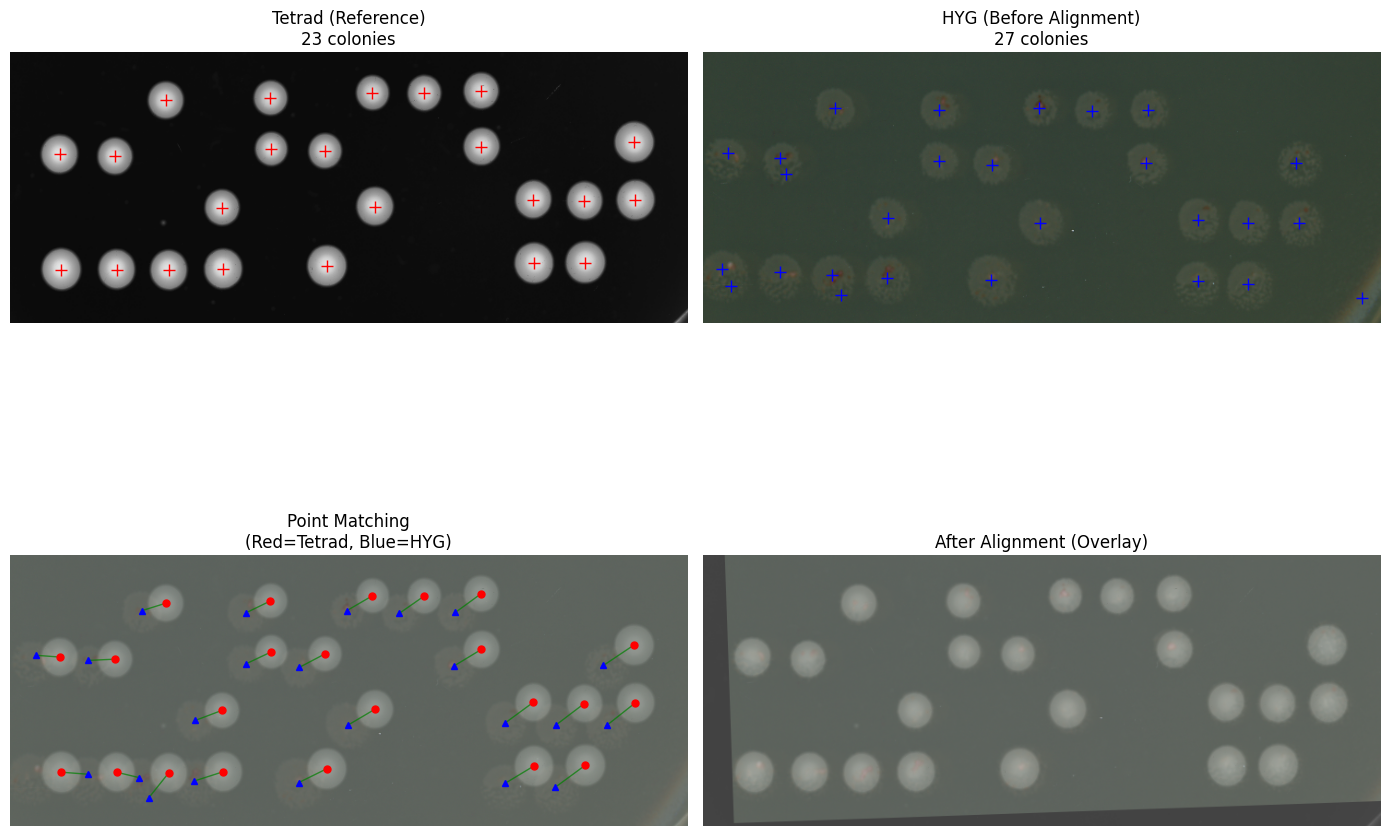

In [12]:
# ============================================================
# 9. Image Alignment Demonstration
# ============================================================

# Simplified colony detection function
def detect_colonies_simple(img, is_hyg=False, min_area=20):
    """Detect colony centroids"""
    if is_hyg:
        gray = img[:, :, 0].astype(float)  # HYG: Red channel
    else:
        gray = np.mean(img, axis=2)  # Tetrad: Mean value
    
    blurred = gaussian(gray, sigma=1.0, preserve_range=True)
    
    try:
        thresh = threshold_otsu(blurred)
        binary = blurred > thresh
    except:
        binary = blurred > 100
    
    binary = morphology.binary_opening(binary, morphology.disk(3))
    label_img = measure.label(binary)
    props = measure.regionprops(label_img)
    
    centroids = [(p.centroid[1], p.centroid[0]) for p in props if p.area > min_area]
    return centroids, binary

# Resize HYG to match Tetrad
h_ref, w_ref = tetrad_plate.shape[:2]
hyg_resized = cv2.resize(hyg_plate, (w_ref, h_ref))

# Detect colonies
centroids_tetrad, mask_tetrad = detect_colonies_simple(tetrad_plate, is_hyg=False)
centroids_hyg, mask_hyg = detect_colonies_simple(hyg_resized, is_hyg=True)

print(f"✅ Tetrad: {len(centroids_tetrad)} colonies")
print(f"   HYG:    {len(centroids_hyg)} colonies")

# Hungarian algorithm matching
hyg_aligned = hyg_resized  # Default
M_estimated = None

if len(centroids_tetrad) >= 3 and len(centroids_hyg) >= 3:
    pts_tetrad = np.array(centroids_tetrad, dtype=np.float32)
    pts_hyg = np.array(centroids_hyg, dtype=np.float32)
    
    dist_matrix = distance.cdist(pts_tetrad, pts_hyg)
    row_ind, col_ind = linear_sum_assignment(dist_matrix)
    
    # Filter matches with large distance
    max_dist = max(h_ref, w_ref) * 0.15
    matched_tetrad, matched_hyg = [], []
    
    for r, c in zip(row_ind, col_ind):
        if dist_matrix[r, c] < max_dist:
            matched_tetrad.append(pts_tetrad[r])
            matched_hyg.append(pts_hyg[c])
    
    print(f"   Matched: {len(matched_tetrad)} pairs")
    
    if len(matched_tetrad) >= 3:
        matched_tetrad = np.array(matched_tetrad, dtype=np.float32)
        matched_hyg = np.array(matched_hyg, dtype=np.float32)
        
        # RANSAC transform estimation
        M_estimated, inliers = cv2.estimateAffinePartial2D(
            matched_hyg, matched_tetrad, method=cv2.RANSAC, ransacReprojThreshold=5.0
        )
        
        hyg_aligned = cv2.warpAffine(hyg_resized, M_estimated, (w_ref, h_ref))
        
        # Extract transform parameters
        scale = np.sqrt(M_estimated[0, 0]**2 + M_estimated[0, 1]**2)
        angle = np.degrees(np.arctan2(M_estimated[1, 0], M_estimated[0, 0]))
        tx, ty = M_estimated[0, 2], M_estimated[1, 2]
        
        print(f"\n📊 Estimated Transform:")
        print(f"   Scale: {scale:.4f}")
        print(f"   Rotation: {angle:.2f}°")
        print(f"   Translation: ({tx:.1f}, {ty:.1f}) px")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[0, 0].plot(x, y, 'r+', markersize=8)
axes[0, 0].set_title(f'Tetrad (Reference)\n{len(centroids_tetrad)} colonies')
axes[0, 0].axis('off')

axes[0, 1].imshow(hyg_resized)
for (x, y) in centroids_hyg:
    axes[0, 1].plot(x, y, 'b+', markersize=8)
axes[0, 1].set_title(f'HYG (Before Alignment)\n{len(centroids_hyg)} colonies')
axes[0, 1].axis('off')

# Matching visualization
axes[1, 0].imshow(tetrad_plate, alpha=0.5)
axes[1, 0].imshow(hyg_resized, alpha=0.5)
if M_estimated is not None:
    for t, h in zip(matched_tetrad, matched_hyg):
        axes[1, 0].plot([t[0], h[0]], [t[1], h[1]], 'g-', linewidth=1, alpha=0.7)
        axes[1, 0].plot(t[0], t[1], 'ro', markersize=5)
        axes[1, 0].plot(h[0], h[1], 'b^', markersize=5)
axes[1, 0].set_title('Point Matching\n(Red=Tetrad, Blue=HYG)')
axes[1, 0].axis('off')

# Alignment result
axes[1, 1].imshow(tetrad_plate, alpha=0.5)
axes[1, 1].imshow(hyg_aligned, alpha=0.5)
axes[1, 1].set_title('After Alignment (Overlay)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

---
## 第十章：网格拟合与旋转校正

### 10.1 基因型判断的两种方法

| 方法 | 原理 | 优点 | 缺点 |
|------|------|------|------|
| **距离匹配** | 比较 Tetrad 和 HYG 的菌落距离 | 简单直观 | 受 HYG 检测质量影响 |
| **网格信号** | 在 HYG 上固定位置测量信号 | 稳定可靠 | 需要准确的网格 |

### 10.2 网格拟合方法

对于 4 行 × 12 列的四分体平板：

1. **简单边界框** — 取所有质心的边界，均匀划分
2. **PCA 旋转校正** — 先检测旋转角度，再拟合网格
3. **优化方法** — 最小化网格点到质心的距离

### 10.3 PCA 旋转校正原理

当平板在扫描时存在轻微旋转，简单的边界框方法会产生偏差。PCA (主成分分析) 可以：

1. **检测旋转角度**: 第一主成分 (PC1) 方向即为菌落行的主方向
2. **计算旋转矩阵**: $R = \begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}$
3. **校正步骤**:
   - 将质心旋转到水平/垂直对齐状态
   - 在对齐后的坐标系中拟合网格
   - 将网格旋转回原始坐标系

### 10.4 Essential Gene 的特殊情况

对于 **Essential Gene**，每个 tetrad 只有 **2 个存活孢子** (DEL 致死)，需要：
- 自动检测实际的行数
- 处理缺失位置

✅ Grid fitted:
   X spacing: 56.8 px
   Y spacing: 64.8 px

📊 Genotyping Result:
   Threshold: 55.6
   DEL (HYG-R): 24
   WT (HYG-S):  24


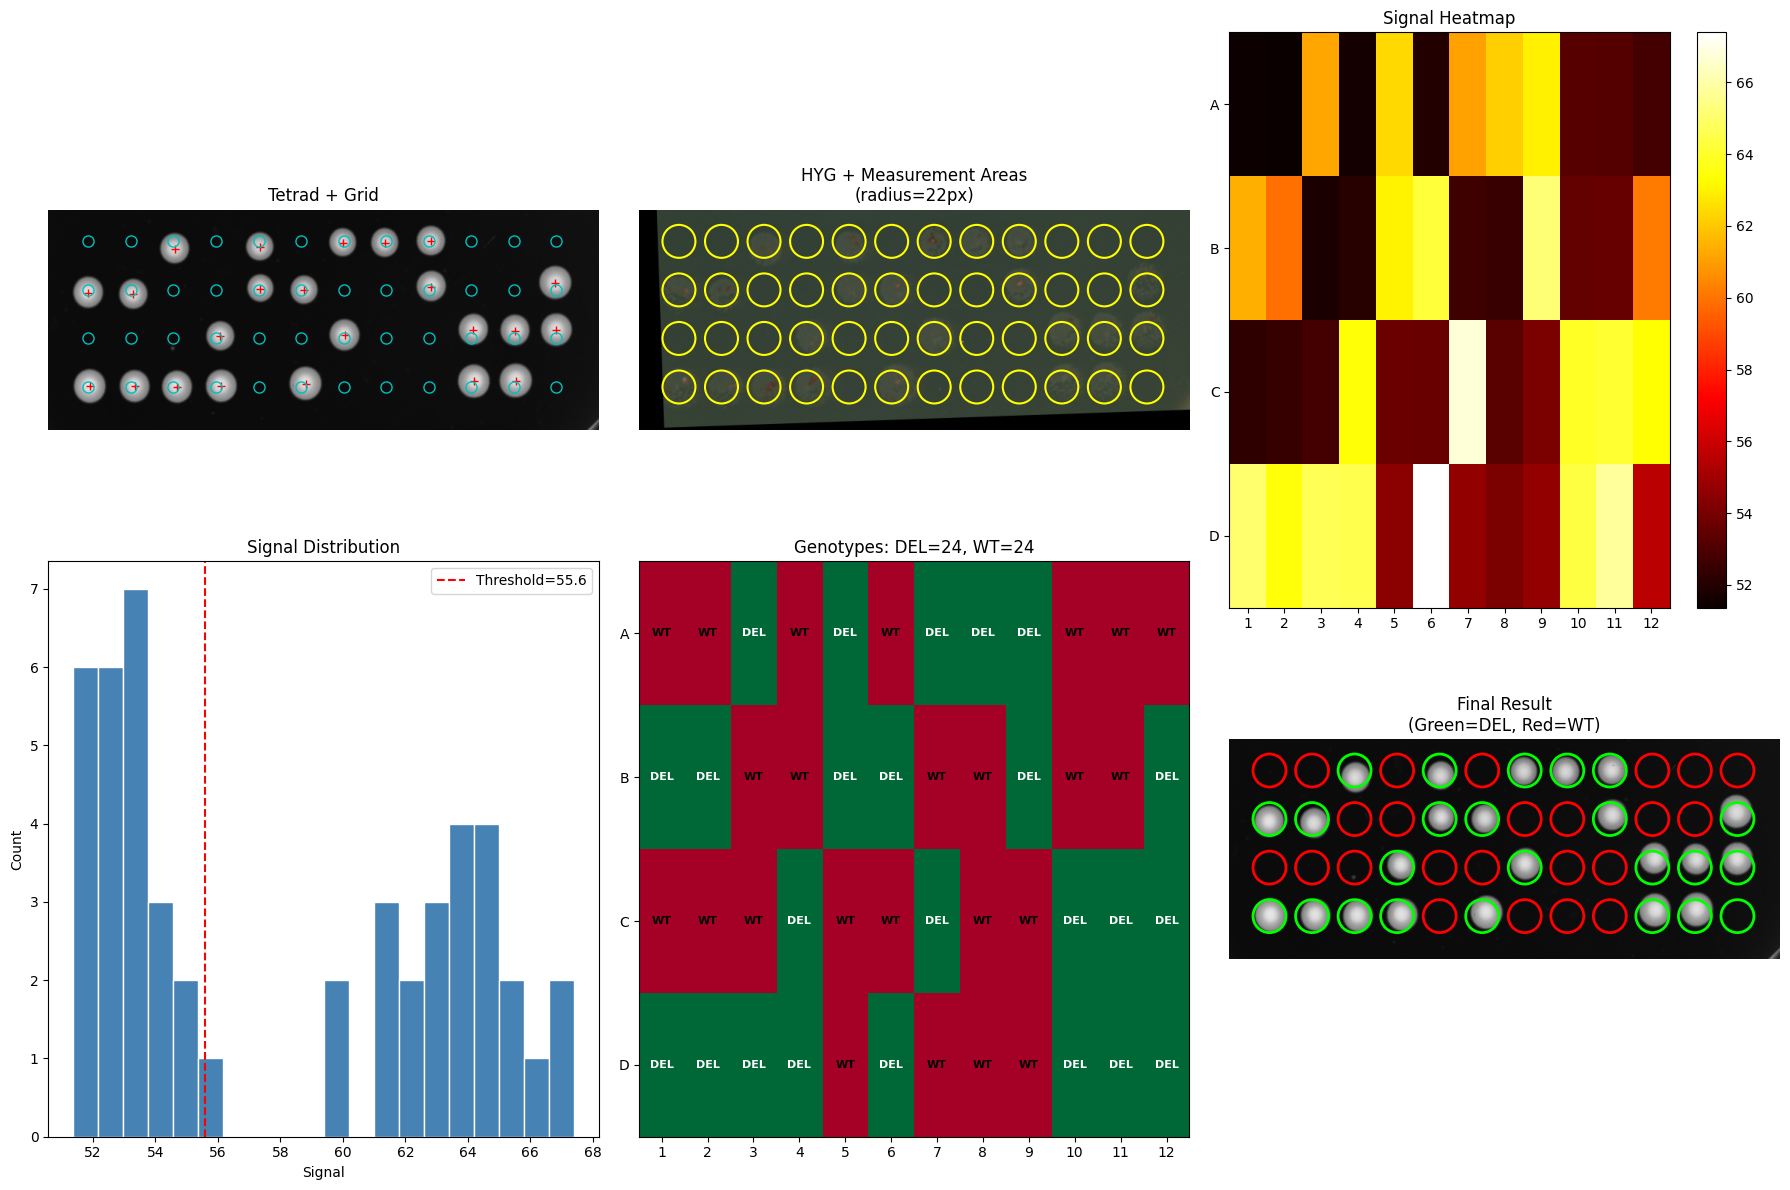

In [16]:
# ============================================================
# 10.1 Simple Grid Fitting
# ============================================================

def fit_grid_simple(centroids, n_rows=4, n_cols=12):
    """Fit grid from centroid bounding box"""
    pts = np.array(centroids)
    x_min, x_max = pts[:, 0].min(), pts[:, 0].max()
    y_min, y_max = pts[:, 1].min(), pts[:, 1].max()
    
    x_spacing = (x_max - x_min) / (n_cols - 1) if n_cols > 1 else 0
    y_spacing = (y_max - y_min) / (n_rows - 1) if n_rows > 1 else 0
    
    grid = np.zeros((n_rows, n_cols, 2))
    for row in range(n_rows):
        for col in range(n_cols):
            grid[row, col, 0] = x_min + col * x_spacing
            grid[row, col, 1] = y_min + row * y_spacing
    
    return grid, {'x_spacing': x_spacing, 'y_spacing': y_spacing}

# Fit grid
grid_centers, grid_params = fit_grid_simple(centroids_tetrad, n_rows=4, n_cols=12)

print(f"✅ Grid fitted:")
print(f"   X spacing: {grid_params['x_spacing']:.1f} px")
print(f"   Y spacing: {grid_params['y_spacing']:.1f} px")

# ============================================================
# 10.2 Measure HYG Signal at Grid Positions
# ============================================================

def measure_grid_signal(image, grid, radius=15):
    """Measure signal intensity at each grid position"""
    n_rows, n_cols = grid.shape[:2]
    h, w = image.shape[:2]
    
    # Use red channel (HYG green background)
    gray = image[:, :, 0].astype(float) if image.ndim == 3 else image.astype(float)
    
    signals = np.zeros((n_rows, n_cols))
    
    for row in range(n_rows):
        for col in range(n_cols):
            cx, cy = int(grid[row, col, 0]), int(grid[row, col, 1])
            
            x1, x2 = max(0, cx - radius), min(w, cx + radius + 1)
            y1, y2 = max(0, cy - radius), min(h, cy + radius + 1)
            
            if x2 > x1 and y2 > y1:
                signals[row, col] = np.mean(gray[y1:y2, x1:x2])
    
    return signals

# Measure signal
measure_radius = int(grid_params['y_spacing'] * 0.35)
signals = measure_grid_signal(hyg_aligned, grid_centers, radius=measure_radius)

# Otsu threshold for genotyping
threshold = threshold_otsu(signals.flatten())
genotypes = np.where(signals > threshold, 'DEL', 'WT')

del_count = np.sum(genotypes == 'DEL')
wt_count = np.sum(genotypes == 'WT')

print(f"\n📊 Genotyping Result:")
print(f"   Threshold: {threshold:.1f}")
print(f"   DEL (HYG-R): {del_count}")
print(f"   WT (HYG-S):  {wt_count}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Tetrad + grid
axes[0, 0].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[0, 0].plot(x, y, 'r+', markersize=6)
for row in range(4):
    for col in range(12):
        gx, gy = grid_centers[row, col]
        axes[0, 0].plot(gx, gy, 'co', markersize=8, fillstyle='none')
axes[0, 0].set_title('Tetrad + Grid')
axes[0, 0].axis('off')

# HYG + measurement areas
axes[0, 1].imshow(hyg_aligned)
for row in range(4):
    for col in range(12):
        gx, gy = grid_centers[row, col]
        circ = Circle((gx, gy), radius=measure_radius, color='yellow', fill=False, linewidth=1.5)
        axes[0, 1].add_patch(circ)
axes[0, 1].set_title(f'HYG + Measurement Areas\n(radius={measure_radius}px)')
axes[0, 1].axis('off')

# Signal heatmap
im = axes[0, 2].imshow(signals, cmap='hot', aspect='auto')
axes[0, 2].set_title('Signal Heatmap')
axes[0, 2].set_xticks(range(12))
axes[0, 2].set_yticks(range(4))
axes[0, 2].set_xticklabels([str(i+1) for i in range(12)])
axes[0, 2].set_yticklabels(['A', 'B', 'C', 'D'])
plt.colorbar(im, ax=axes[0, 2])

# Signal distribution
axes[1, 0].hist(signals.flatten(), bins=20, color='steelblue', edgecolor='white')
axes[1, 0].axvline(threshold, color='red', linestyle='--', label=f'Threshold={threshold:.1f}')
axes[1, 0].set_xlabel('Signal')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Signal Distribution')
axes[1, 0].legend()

# Genotype table
gt_colors = np.where(genotypes == 'DEL', 1, 0)
axes[1, 1].imshow(gt_colors, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
for row in range(4):
    for col in range(12):
        color = 'white' if genotypes[row, col] == 'DEL' else 'black'
        axes[1, 1].text(col, row, genotypes[row, col], ha='center', va='center', 
                       fontsize=8, color=color, fontweight='bold')
axes[1, 1].set_title(f'Genotypes: DEL={del_count}, WT={wt_count}')
axes[1, 1].set_xticks(range(12))
axes[1, 1].set_yticks(range(4))
axes[1, 1].set_xticklabels([str(i+1) for i in range(12)])
axes[1, 1].set_yticklabels(['A', 'B', 'C', 'D'])

# Final result
axes[1, 2].imshow(tetrad_plate)
for row in range(4):
    for col in range(12):
        gx, gy = grid_centers[row, col]
        color = 'lime' if genotypes[row, col] == 'DEL' else 'red'
        circ = Circle((gx, gy), radius=measure_radius, color=color, fill=False, linewidth=2)
        axes[1, 2].add_patch(circ)
axes[1, 2].set_title('Final Result\n(Green=DEL, Red=WT)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

PCA Rotation Correction Demonstration

📐 PCA Analysis:
   Rotation angle: 177.66°
   Explained variance ratio: [0.88964145 0.11035855]
   Detected rotation angle: 177.66°

✅ Grid with PCA correction:
   X spacing: 56.9 px
   Y spacing: 64.8 px


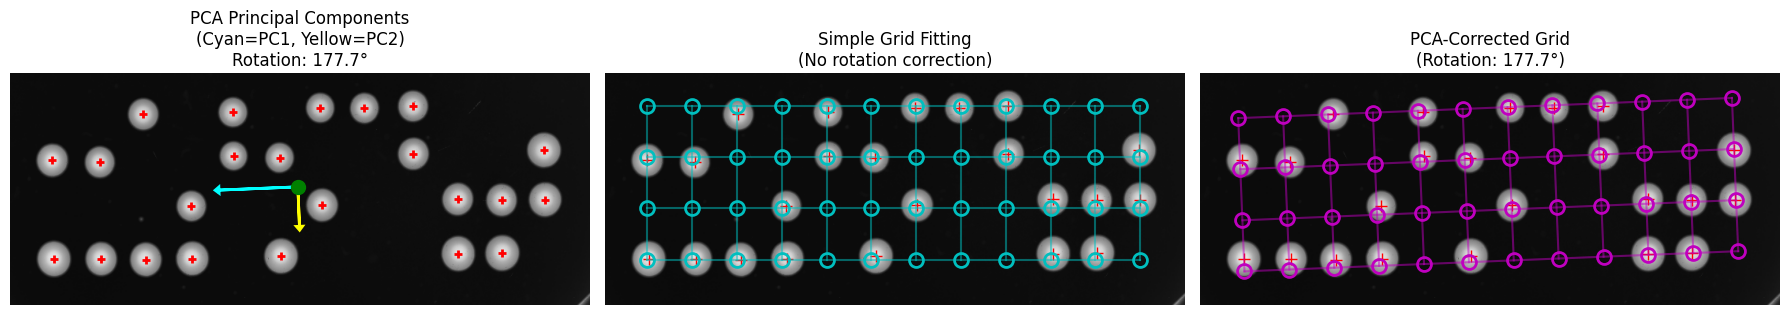


📊 Grid Alignment Error Comparison:
   Simple grid:      33.80 px (avg distance to nearest centroid)
   PCA-corrected:    33.24 px
   Improvement:      1.7%


In [18]:
# ============================================================
# 10.2 PCA Rotation Correction for Grid Fitting
# ============================================================

# Note: We implement PCA manually using NumPy (SVD) to avoid sklearn dependency

def pca_numpy(data, n_components=2):
    """
    Simple PCA implementation using NumPy SVD.
    
    Args:
        data: (n_samples, n_features) array, should be centered
        n_components: Number of principal components to return
        
    Returns:
        components: Principal component directions (n_components, n_features)
        explained_variance_ratio: Proportion of variance explained by each component
    """
    # SVD decomposition: data = U @ S @ Vt
    U, S, Vt = np.linalg.svd(data, full_matrices=False)
    
    # Principal components are rows of Vt
    components = Vt[:n_components]
    
    # Explained variance ratio
    variance = (S ** 2) / (len(data) - 1)
    explained_variance_ratio = variance[:n_components] / variance.sum()
    
    return components, explained_variance_ratio


def detect_rotation_angle_pca(centroids):
    """
    Use PCA to detect rotation angle of colony grid.
    
    The first principal component (PC1) should align with the row direction.
    The angle between PC1 and the x-axis is the rotation angle.
    
    Args:
        centroids: List of (x, y) centroid coordinates
        
    Returns:
        angle_deg: Rotation angle in degrees
        components: PCA components
        center: Center point of centroids
    """
    pts = np.array(centroids)
    
    # Center the points
    center = pts.mean(axis=0)
    pts_centered = pts - center
    
    # Apply PCA using NumPy SVD
    components, explained_variance_ratio = pca_numpy(pts_centered, n_components=2)
    
    # Get the first principal component direction
    pc1 = components[0]  # Direction of maximum variance (row direction)
    
    # Calculate angle with x-axis
    angle_rad = np.arctan2(pc1[1], pc1[0])
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg, components, center, explained_variance_ratio


def rotate_points(points, angle_deg, center):
    """Rotate points around a center by given angle."""
    angle_rad = np.radians(angle_deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    
    pts = np.array(points)
    pts_centered = pts - center
    
    # Rotation matrix
    rotated = np.zeros_like(pts_centered)
    rotated[:, 0] = pts_centered[:, 0] * cos_a - pts_centered[:, 1] * sin_a
    rotated[:, 1] = pts_centered[:, 0] * sin_a + pts_centered[:, 1] * cos_a
    
    return rotated + center


def fit_grid_with_pca(centroids, n_rows=4, n_cols=12):
    """
    Fit grid using PCA rotation correction.
    
    Steps:
    1. Detect rotation angle using PCA
    2. Rotate centroids to align with axes
    3. Fit bounding box grid on rotated points
    4. Rotate grid back to original orientation
    """
    pts = np.array(centroids)
    
    # Step 1: Detect rotation angle
    angle_deg, components, center, variance_ratio = detect_rotation_angle_pca(centroids)
    print(f"   Detected rotation angle: {angle_deg:.2f}°")
    
    # Step 2: Rotate centroids to align with axes (undo the rotation)
    pts_aligned = rotate_points(pts, -angle_deg, center)
    
    # Step 3: Fit grid on aligned points
    x_min, x_max = pts_aligned[:, 0].min(), pts_aligned[:, 0].max()
    y_min, y_max = pts_aligned[:, 1].min(), pts_aligned[:, 1].max()
    
    x_spacing = (x_max - x_min) / (n_cols - 1) if n_cols > 1 else 0
    y_spacing = (y_max - y_min) / (n_rows - 1) if n_rows > 1 else 0
    
    # Create aligned grid
    grid_aligned = np.zeros((n_rows, n_cols, 2))
    for row in range(n_rows):
        for col in range(n_cols):
            grid_aligned[row, col, 0] = x_min + col * x_spacing
            grid_aligned[row, col, 1] = y_min + row * y_spacing
    
    # Step 4: Rotate grid back to original orientation
    grid_flat = grid_aligned.reshape(-1, 2)
    grid_rotated = rotate_points(grid_flat, angle_deg, center)
    grid = grid_rotated.reshape(n_rows, n_cols, 2)
    
    return grid, {
        'x_spacing': x_spacing, 
        'y_spacing': y_spacing,
        'rotation_angle': angle_deg,
        'center': center,
        'components': components,
        'explained_variance_ratio': variance_ratio
    }


# Demonstrate PCA rotation correction
print("=" * 60)
print("PCA Rotation Correction Demonstration")
print("=" * 60)

# Detect rotation angle
angle_deg, components, center, variance_ratio = detect_rotation_angle_pca(centroids_tetrad)
print(f"\n📐 PCA Analysis:")
print(f"   Rotation angle: {angle_deg:.2f}°")
print(f"   Explained variance ratio: {variance_ratio}")

# Fit grid with PCA correction
grid_pca, params_pca = fit_grid_with_pca(centroids_tetrad, n_rows=4, n_cols=12)

print(f"\n✅ Grid with PCA correction:")
print(f"   X spacing: {params_pca['x_spacing']:.1f} px")
print(f"   Y spacing: {params_pca['y_spacing']:.1f} px")

# Visualization: Compare simple vs PCA grid fitting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original centroids
axes[0].imshow(tetrad_plate)
pts = np.array(centroids_tetrad)
axes[0].scatter(pts[:, 0], pts[:, 1], c='red', s=30, marker='+', linewidths=2)

# Draw PCA principal components
pc1 = components[0] * 100  # Scale for visibility
pc2 = components[1] * 50
axes[0].arrow(center[0], center[1], pc1[0], pc1[1], 
              head_width=8, head_length=5, fc='cyan', ec='cyan', linewidth=2)
axes[0].arrow(center[0], center[1], pc2[0], pc2[1], 
              head_width=8, head_length=5, fc='yellow', ec='yellow', linewidth=2)
axes[0].plot(center[0], center[1], 'go', markersize=10)
axes[0].set_title(f'PCA Principal Components\n(Cyan=PC1, Yellow=PC2)\nRotation: {angle_deg:.1f}°')
axes[0].axis('off')

# Simple grid (no rotation correction)
axes[1].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[1].plot(x, y, 'r+', markersize=8)
for row in range(4):
    for col in range(12):
        gx, gy = grid_centers[row, col]
        axes[1].plot(gx, gy, 'co', markersize=10, fillstyle='none', markeredgewidth=2)
# Draw grid lines
for row in range(4):
    xs = [grid_centers[row, col, 0] for col in range(12)]
    ys = [grid_centers[row, col, 1] for col in range(12)]
    axes[1].plot(xs, ys, 'c-', alpha=0.5)
for col in range(12):
    xs = [grid_centers[row, col, 0] for row in range(4)]
    ys = [grid_centers[row, col, 1] for row in range(4)]
    axes[1].plot(xs, ys, 'c-', alpha=0.5)
axes[1].set_title('Simple Grid Fitting\n(No rotation correction)')
axes[1].axis('off')

# PCA-corrected grid
axes[2].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[2].plot(x, y, 'r+', markersize=8)
for row in range(4):
    for col in range(12):
        gx, gy = grid_pca[row, col]
        axes[2].plot(gx, gy, 'mo', markersize=10, fillstyle='none', markeredgewidth=2)
# Draw grid lines
for row in range(4):
    xs = [grid_pca[row, col, 0] for col in range(12)]
    ys = [grid_pca[row, col, 1] for col in range(12)]
    axes[2].plot(xs, ys, 'm-', alpha=0.5)
for col in range(12):
    xs = [grid_pca[row, col, 0] for row in range(4)]
    ys = [grid_pca[row, col, 1] for row in range(4)]
    axes[2].plot(xs, ys, 'm-', alpha=0.5)
axes[2].set_title(f'PCA-Corrected Grid\n(Rotation: {angle_deg:.1f}°)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Calculate alignment error for both methods
def calculate_grid_error(grid, centroids):
    """Calculate total distance from grid points to nearest centroids"""
    pts = np.array(centroids)
    grid_flat = grid.reshape(-1, 2)
    
    total_error = 0
    for gp in grid_flat:
        dists = np.linalg.norm(pts - gp, axis=1)
        total_error += np.min(dists)
    
    return total_error / len(grid_flat)

error_simple = calculate_grid_error(grid_centers, centroids_tetrad)
error_pca = calculate_grid_error(grid_pca, centroids_tetrad)

print(f"\n📊 Grid Alignment Error Comparison:")
print(f"   Simple grid:      {error_simple:.2f} px (avg distance to nearest centroid)")
print(f"   PCA-corrected:    {error_pca:.2f} px")
print(f"   Improvement:      {(error_simple - error_pca) / error_simple * 100:.1f}%")

---
## 第十一章：改进的信号检测 — SNR 方法

### 11.1 简单阈值方法的问题

对于 **Essential Gene** 的情况：
- Tetrad 平板：只有 2 个 WT 存活，2 个 DEL 致死
- HYG 平板：WT 无抗性不长，DEL 致死也不长
- 但转印痕迹可能被误判为信号！

### 11.2 SNR (信噪比) 方法

**信噪比** = $\frac{\text{信号} - \text{背景}}{\text{背景标准差}}$

| SNR 值 | 意义 |
|--------|------|
| < 1 | 与背景无差异 |
| 1-2 | 可能是噪声 |
| **> 2** | 真实信号 |
| > 3 | 强信号 |

### 11.3 背景估计方法

在网格点**之间**的区域采样，这些位置应该没有菌落。

📊 Background: mean=53.7, std=3.8
   SNR range: -0.62 ~ 3.65

Results with different SNR thresholds:
   SNR > 1.5: DEL=23, WT=25
   SNR > 2.0: DEL=20, WT=28
   SNR > 2.5: DEL=14, WT=34
   SNR > 3.0: DEL=5, WT=43


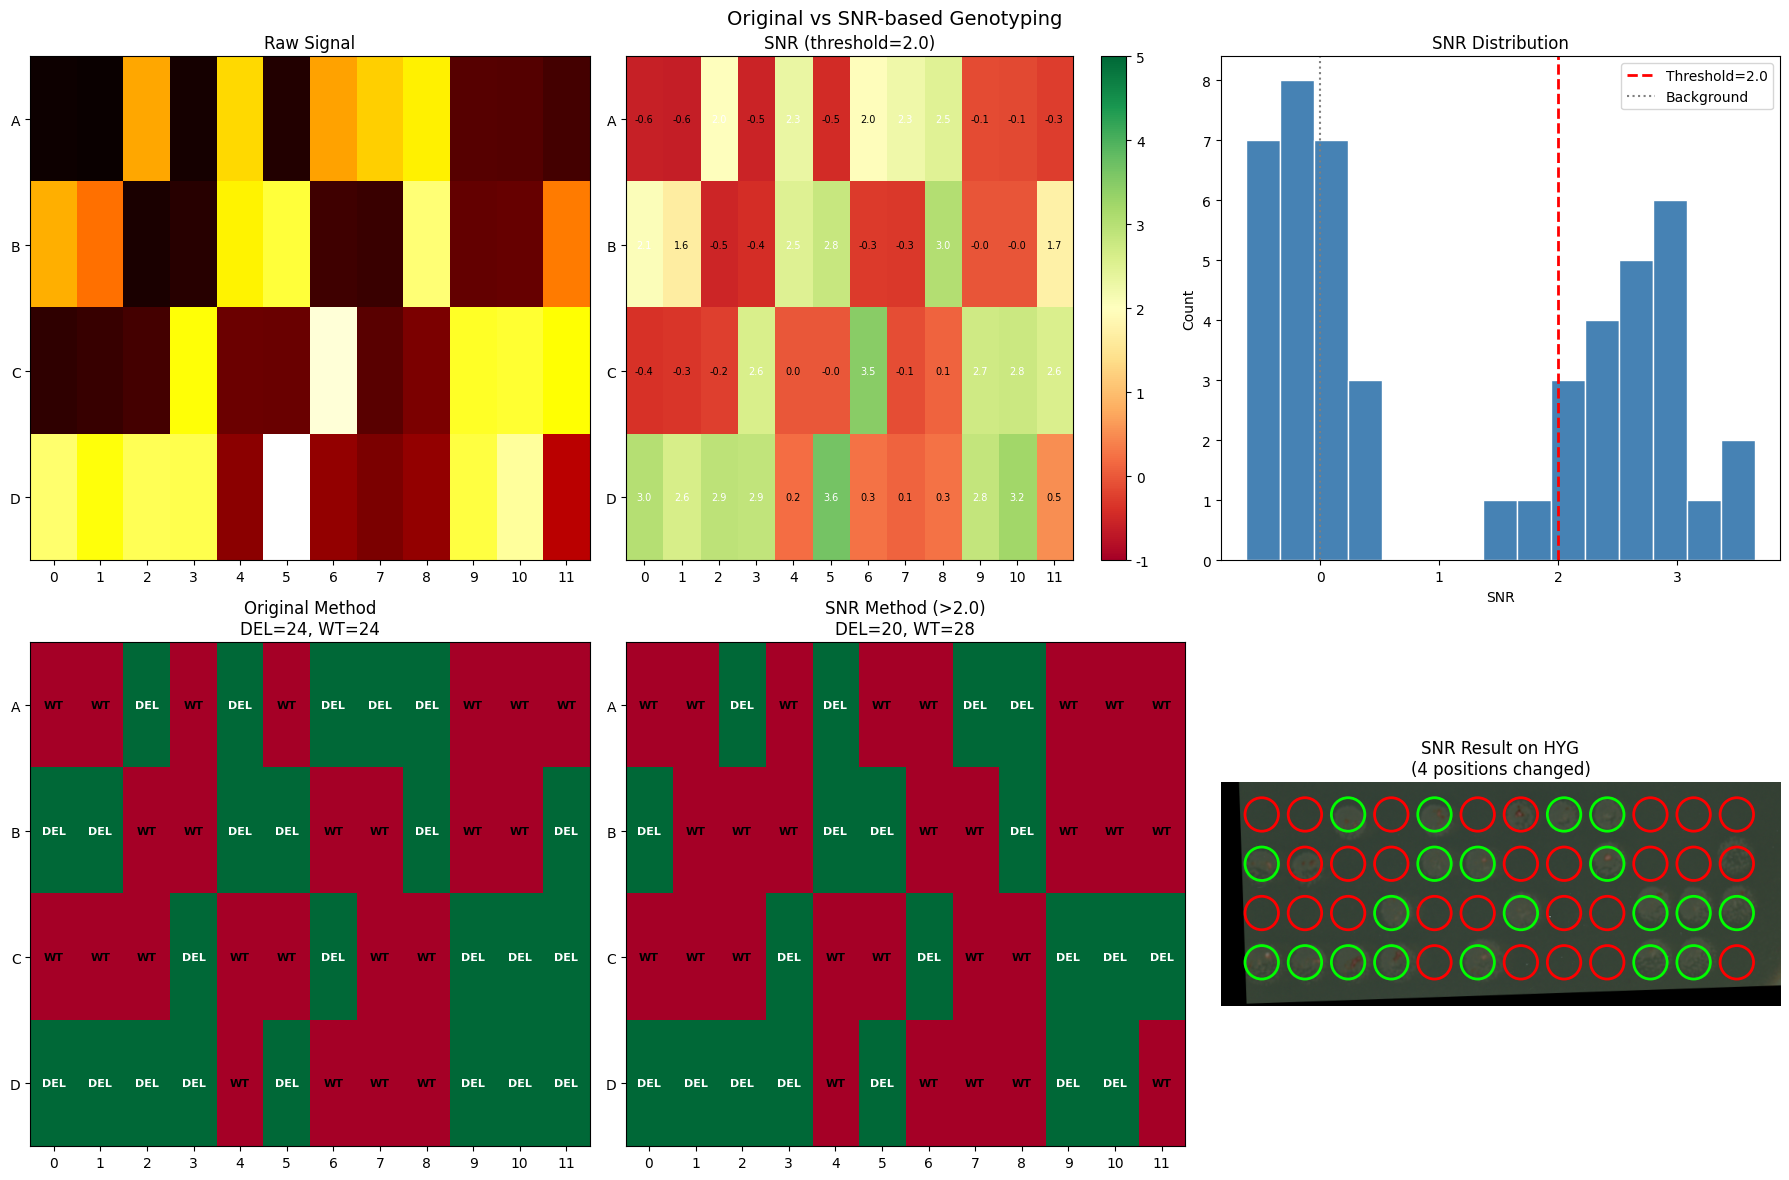


📝 Method comparison:
   Original method (Otsu): DEL=24, WT=24
   SNR method (>2.0): DEL=20, WT=28
   Changed positions: 4



In [19]:
# ============================================================
# 11. SNR Method — Improved Signal Detection
# ============================================================

def estimate_background(image, grid, grid_params):
    """Estimate background intensity: sample between grid points"""
    h, w = image.shape[:2]
    gray = image[:, :, 0].astype(float) if image.ndim == 3 else image.astype(float)
    
    n_rows, n_cols = grid.shape[:2]
    x_spacing = grid_params['x_spacing']
    y_spacing = grid_params['y_spacing']
    
    bg_samples = []
    
    # Sample between columns
    for row in range(n_rows):
        for col in range(n_cols - 1):
            x1, y1 = grid[row, col]
            x2, y2 = grid[row, col + 1]
            mid_x, mid_y = int((x1 + x2) / 2), int((y1 + y2) / 2)
            
            if 5 < mid_x < w - 5 and 5 < mid_y < h - 5:
                bg_samples.append(np.mean(gray[mid_y-3:mid_y+4, mid_x-3:mid_x+4]))
    
    # Sample between rows
    for row in range(n_rows - 1):
        for col in range(n_cols):
            x1, y1 = grid[row, col]
            x2, y2 = grid[row + 1, col]
            mid_x, mid_y = int((x1 + x2) / 2), int((y1 + y2) / 2)
            
            if 5 < mid_x < w - 5 and 5 < mid_y < h - 5:
                bg_samples.append(np.mean(gray[mid_y-3:mid_y+4, mid_x-3:mid_x+4]))
    
    return np.median(bg_samples), np.std(bg_samples)


def measure_signal_with_snr(image, grid, radius, bg_mean, bg_std):
    """Calculate signal and SNR"""
    n_rows, n_cols = grid.shape[:2]
    h, w = image.shape[:2]
    gray = image[:, :, 0].astype(float) if image.ndim == 3 else image.astype(float)
    
    raw_signals = np.zeros((n_rows, n_cols))
    snr = np.zeros((n_rows, n_cols))
    
    for row in range(n_rows):
        for col in range(n_cols):
            cx, cy = int(grid[row, col, 0]), int(grid[row, col, 1])
            
            x1, x2 = max(0, cx - radius), min(w, cx + radius + 1)
            y1, y2 = max(0, cy - radius), min(h, cy + radius + 1)
            
            if x2 > x1 and y2 > y1:
                signal = np.mean(gray[y1:y2, x1:x2])
                raw_signals[row, col] = signal
                snr[row, col] = (signal - bg_mean) / bg_std if bg_std > 0 else 0
    
    return raw_signals, snr


def genotype_by_snr(snr, snr_threshold=2.0):
    """Genotype based on SNR"""
    genotypes = np.where(snr > snr_threshold, 'DEL', 'WT')
    return genotypes

# Apply SNR method
bg_mean, bg_std = estimate_background(hyg_aligned, grid_centers, grid_params)
print(f"📊 Background: mean={bg_mean:.1f}, std={bg_std:.1f}")

raw_signals, snr = measure_signal_with_snr(hyg_aligned, grid_centers, measure_radius, bg_mean, bg_std)
print(f"   SNR range: {snr.min():.2f} ~ {snr.max():.2f}")

# Test with different thresholds
print("\nResults with different SNR thresholds:")
for snr_th in [1.5, 2.0, 2.5, 3.0]:
    gt = genotype_by_snr(snr, snr_th)
    print(f"   SNR > {snr_th}: DEL={np.sum(gt=='DEL')}, WT={np.sum(gt=='WT')}")

# Use recommended threshold
genotypes_snr = genotype_by_snr(snr, snr_threshold=2.0)
del_snr = np.sum(genotypes_snr == 'DEL')
wt_snr = np.sum(genotypes_snr == 'WT')

# Visualization comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Signal analysis
axes[0, 0].imshow(raw_signals, cmap='hot', aspect='auto')
axes[0, 0].set_title('Raw Signal')
axes[0, 0].set_xticks(range(12))
axes[0, 0].set_yticks(range(4))
axes[0, 0].set_yticklabels(['A', 'B', 'C', 'D'])

im = axes[0, 1].imshow(snr, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=5)
axes[0, 1].set_title('SNR (threshold=2.0)')
axes[0, 1].set_xticks(range(12))
axes[0, 1].set_yticks(range(4))
axes[0, 1].set_yticklabels(['A', 'B', 'C', 'D'])
for row in range(4):
    for col in range(12):
        color = 'white' if snr[row, col] >= 2.0 else 'black'
        axes[0, 1].text(col, row, f'{snr[row, col]:.1f}', ha='center', va='center', 
                       fontsize=7, color=color)
plt.colorbar(im, ax=axes[0, 1])

axes[0, 2].hist(snr.flatten(), bins=15, color='steelblue', edgecolor='white')
axes[0, 2].axvline(2.0, color='red', linestyle='--', linewidth=2, label='Threshold=2.0')
axes[0, 2].axvline(0, color='gray', linestyle=':', label='Background')
axes[0, 2].set_xlabel('SNR')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('SNR Distribution')
axes[0, 2].legend()

# Row 2: Method comparison
gt_orig = np.where(genotypes == 'DEL', 1, 0)
axes[1, 0].imshow(gt_orig, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
for row in range(4):
    for col in range(12):
        color = 'white' if genotypes[row, col] == 'DEL' else 'black'
        axes[1, 0].text(col, row, genotypes[row, col], ha='center', va='center', 
                       fontsize=8, color=color, fontweight='bold')
axes[1, 0].set_title(f'Original Method\nDEL={del_count}, WT={wt_count}')
axes[1, 0].set_xticks(range(12))
axes[1, 0].set_yticks(range(4))
axes[1, 0].set_yticklabels(['A', 'B', 'C', 'D'])

gt_snr = np.where(genotypes_snr == 'DEL', 1, 0)
axes[1, 1].imshow(gt_snr, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
for row in range(4):
    for col in range(12):
        color = 'white' if genotypes_snr[row, col] == 'DEL' else 'black'
        axes[1, 1].text(col, row, genotypes_snr[row, col], ha='center', va='center', 
                       fontsize=8, color=color, fontweight='bold')
axes[1, 1].set_title(f'SNR Method (>2.0)\nDEL={del_snr}, WT={wt_snr}')
axes[1, 1].set_xticks(range(12))
axes[1, 1].set_yticks(range(4))
axes[1, 1].set_yticklabels(['A', 'B', 'C', 'D'])

# Change comparison
changed = genotypes != genotypes_snr
change_count = np.sum(changed)
axes[1, 2].imshow(hyg_aligned)
for row in range(4):
    for col in range(12):
        gx, gy = grid_centers[row, col]
        color = 'lime' if genotypes_snr[row, col] == 'DEL' else 'red'
        circ = Circle((gx, gy), radius=measure_radius, color=color, fill=False, linewidth=2)
        axes[1, 2].add_patch(circ)
axes[1, 2].set_title(f'SNR Result on HYG\n({change_count} positions changed)')
axes[1, 2].axis('off')

plt.suptitle('Original vs SNR-based Genotyping', fontsize=14)
plt.tight_layout()
plt.show()

print(f"""
📝 Method comparison:
   Original method (Otsu): DEL={del_count}, WT={wt_count}
   SNR method (>2.0): DEL={del_snr}, WT={wt_snr}
   Changed positions: {change_count}
""")

---
## 📋 总结

### 完整流程回顾

```
┌─────────────────────────────────────────────────────────────┐
│  1. 读取图像          skimage.io.imread                     │
│        ↓                                                     │
│  2. 灰度转换          np.mean / 取单通道                      │
│        ↓                                                     │
│  3. 高斯模糊          filters.gaussian (σ=1.0)               │
│        ↓                                                     │
│  4. Otsu 阈值         filters.threshold_otsu                 │
│        ↓                                                     │
│  5. 形态学开运算      morphology.binary_opening (disk=3)     │
│        ↓                                                     │
│  6. 分水岭分割        segmentation.watershed (如需要)        │
│        ↓                                                     │
│  7. 区域属性提取      measure.label + regionprops            │
│        ↓                                                     │
│  8. 图像对齐          cv2.estimateAffinePartial2D + warpAffine│
│        ↓                                                     │
│  9. 网格拟合          PCA + 边界框                           │
│        ↓                                                     │
│  10. 信号测量         SNR 方法                               │
│        ↓                                                     │
│  11. 基因型判断       SNR > 2.0 → DEL                        │
└─────────────────────────────────────────────────────────────┘
```

### 关键库速查表

| 库 | 主要函数 | 用途 |
|---|---|---|
| `skimage.filters` | `gaussian`, `threshold_otsu` | 模糊、阈值 |
| `skimage.morphology` | `binary_opening`, `disk` | 形态学操作 |
| `skimage.measure` | `label`, `regionprops` | 区域分析 |
| `skimage.segmentation` | `watershed` | 分水岭分割 |
| `scipy.ndimage` | `distance_transform_edt` | 距离变换 |
| `scipy.spatial` | `distance.cdist` | 距离矩阵 |
| `scipy.optimize` | `linear_sum_assignment` | 匈牙利匹配 |
| `cv2` | `estimateAffinePartial2D`, `warpAffine` | 图像对齐 |

### 推荐参数

| 参数 | Tetrad 平板 | HYG 平板 |
|------|------------|---------|
| 灰度方法 | `np.mean()` | 红色通道 |
| 高斯 σ | 1.0 - 2.0 | 0.5 - 1.0 |
| 开运算 disk | 3 | 3 |
| SNR 阈值 | - | 2.0 |

In [ ]:
print("🎉 Tutorial complete!")
print("""
Now you should have mastered:
  ✅ Basic image preprocessing workflow
  ✅ Principles and applications of morphological operations
  ✅ Watershed algorithm for separating fused colonies
  ✅ Image alignment methods
  ✅ Grid-based and SNR genotyping

Below is a complete analysis function that can be used directly to analyze new images.
""")

---
## 🛠️ 实用工具：一键分析函数

下面提供一个完整的分析函数，集成了本教程中所有的步骤：
- 自动检测菌落
- 图像对齐
- 网格拟合
- SNR 信号检测
- 基因型判断

### 使用方法

```python
results = analyze_tetrad_pair(
    tetrad_path='path/to/tetrad.png',
    hyg_path='path/to/hyg.png'
)
```


Usage Example
🔬 Tetrad Analysis
✅ Images loaded: Tetrad (294, 735, 3), HYG (294, 735, 3)
   Detected 23 colonies on Tetrad
   ✅ HYG aligned

📊 Result: DEL=21, WT=27


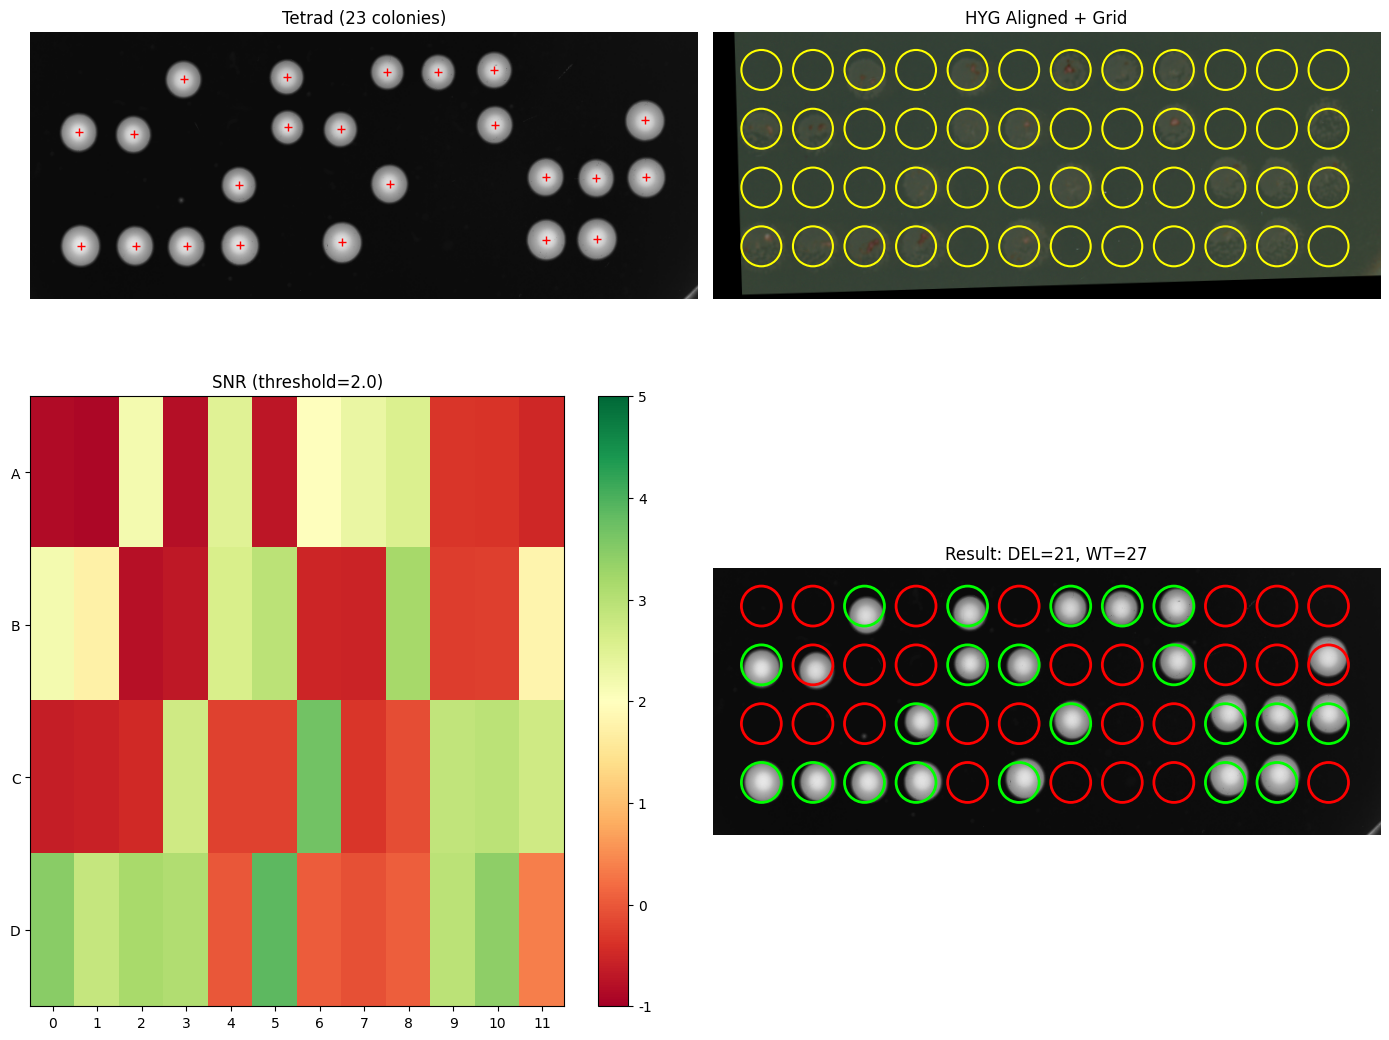

In [15]:
# ============================================================
# Complete Analysis Function
# ============================================================

def analyze_tetrad_pair(tetrad_path, hyg_path, snr_threshold=2.0, show_plots=True):
    """
    One-click analysis of Tetrad and HYG image pair.
    
    Args:
        tetrad_path: Tetrad plate image path
        hyg_path: HYG plate image path
        snr_threshold: SNR threshold (default 2.0)
        show_plots: Whether to show result plots
        
    Returns:
        results: Dictionary containing genotype results
    """
    print("=" * 60)
    print("🔬 Tetrad Analysis")
    print("=" * 60)
    
    # 1. Read images
    tetrad_img = io.imread(tetrad_path)
    hyg_img = io.imread(hyg_path)
    print(f"✅ Images loaded: Tetrad {tetrad_img.shape}, HYG {hyg_img.shape}")
    
    # 2. Detect Tetrad colonies
    gray_tetrad = np.mean(tetrad_img, axis=2)
    blurred = gaussian(gray_tetrad, sigma=2)
    thresh = threshold_otsu(blurred)
    binary = blurred > thresh
    cleaned = morphology.binary_opening(binary, morphology.disk(3))
    labeled = measure.label(cleaned)
    props = measure.regionprops(labeled)
    
    centroids = [(p.centroid[1], p.centroid[0]) for p in props if p.area > 100]
    print(f"   Detected {len(centroids)} colonies on Tetrad")
    
    # 3. Resize and align HYG
    h_ref, w_ref = tetrad_img.shape[:2]
    hyg_resized = cv2.resize(hyg_img, (w_ref, h_ref))
    
    # Detect HYG colonies
    gray_hyg = hyg_resized[:, :, 0].astype(float)
    blurred_hyg = gaussian(gray_hyg, sigma=1)
    thresh_hyg = threshold_otsu(blurred_hyg)
    binary_hyg = blurred_hyg > thresh_hyg
    cleaned_hyg = morphology.binary_opening(binary_hyg, morphology.disk(3))
    labeled_hyg = measure.label(cleaned_hyg)
    props_hyg = measure.regionprops(labeled_hyg)
    centroids_hyg = [(p.centroid[1], p.centroid[0]) for p in props_hyg if p.area > 50]
    
    # Alignment
    hyg_aligned = hyg_resized
    if len(centroids) >= 4 and len(centroids_hyg) >= 4:
        pts_t = np.array(centroids).astype(np.float32)
        pts_h = np.array(centroids_hyg).astype(np.float32)
        
        dist_mat = cdist(pts_t, pts_h)
        row_ind, col_ind = linear_sum_assignment(dist_mat)
        
        valid = dist_mat[row_ind, col_ind] < 50
        if np.sum(valid) >= 4:
            matched_t = pts_t[row_ind[valid]]
            matched_h = pts_h[col_ind[valid]]
            
            M, _ = cv2.estimateAffinePartial2D(
                matched_h.reshape(-1, 1, 2),
                matched_t.reshape(-1, 1, 2),
                method=cv2.RANSAC
            )
            if M is not None:
                hyg_aligned = cv2.warpAffine(hyg_resized, M, (w_ref, h_ref))
                print("   ✅ HYG aligned")
    
    # 4. Fit grid
    pts = np.array(centroids)
    x_min, x_max = pts[:, 0].min(), pts[:, 0].max()
    y_min, y_max = pts[:, 1].min(), pts[:, 1].max()
    
    n_rows, n_cols = 4, 12
    x_sp = (x_max - x_min) / (n_cols - 1)
    y_sp = (y_max - y_min) / (n_rows - 1)
    
    grid = np.zeros((n_rows, n_cols, 2))
    for r in range(n_rows):
        for c in range(n_cols):
            grid[r, c, 0] = x_min + c * x_sp
            grid[r, c, 1] = y_min + r * y_sp
    
    # 5. Measure signal and SNR
    radius = int(y_sp * 0.35)
    gray_hyg_aligned = hyg_aligned[:, :, 0].astype(float)
    
    # Background estimation
    bg_samples = []
    for r in range(n_rows):
        for c in range(n_cols - 1):
            mx = int((grid[r, c, 0] + grid[r, c+1, 0]) / 2)
            my = int((grid[r, c, 1] + grid[r, c+1, 1]) / 2)
            if 5 < mx < w_ref - 5 and 5 < my < h_ref - 5:
                bg_samples.append(np.mean(gray_hyg_aligned[my-3:my+4, mx-3:mx+4]))
    
    bg_mean, bg_std = np.median(bg_samples), np.std(bg_samples)
    
    # Signal measurement
    signals = np.zeros((n_rows, n_cols))
    snr = np.zeros((n_rows, n_cols))
    
    for r in range(n_rows):
        for c in range(n_cols):
            cx, cy = int(grid[r, c, 0]), int(grid[r, c, 1])
            x1, x2 = max(0, cx - radius), min(w_ref, cx + radius + 1)
            y1, y2 = max(0, cy - radius), min(h_ref, cy + radius + 1)
            
            if x2 > x1 and y2 > y1:
                sig = np.mean(gray_hyg_aligned[y1:y2, x1:x2])
                signals[r, c] = sig
                snr[r, c] = (sig - bg_mean) / bg_std if bg_std > 0 else 0
    
    # 6. Genotyping
    genotypes = np.where(snr > snr_threshold, 'DEL', 'WT')
    del_count = np.sum(genotypes == 'DEL')
    wt_count = np.sum(genotypes == 'WT')
    
    print(f"\n📊 Result: DEL={del_count}, WT={wt_count}")
    
    # 7. Visualization
    if show_plots:
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        
        axes[0, 0].imshow(tetrad_img)
        for x, y in centroids:
            axes[0, 0].plot(x, y, 'r+', markersize=6)
        axes[0, 0].set_title(f'Tetrad ({len(centroids)} colonies)')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(hyg_aligned)
        for r in range(n_rows):
            for c in range(n_cols):
                gx, gy = grid[r, c]
                circ = Circle((gx, gy), radius=radius, color='yellow', fill=False, linewidth=1.5)
                axes[0, 1].add_patch(circ)
        axes[0, 1].set_title('HYG Aligned + Grid')
        axes[0, 1].axis('off')
        
        im = axes[1, 0].imshow(snr, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=5)
        axes[1, 0].set_title(f'SNR (threshold={snr_threshold})')
        axes[1, 0].set_xticks(range(12))
        axes[1, 0].set_yticks(range(4))
        axes[1, 0].set_yticklabels(['A', 'B', 'C', 'D'])
        plt.colorbar(im, ax=axes[1, 0])
        
        axes[1, 1].imshow(tetrad_img)
        for r in range(n_rows):
            for c in range(n_cols):
                gx, gy = grid[r, c]
                color = 'lime' if genotypes[r, c] == 'DEL' else 'red'
                circ = Circle((gx, gy), radius=radius, color=color, fill=False, linewidth=2)
                axes[1, 1].add_patch(circ)
        axes[1, 1].set_title(f'Result: DEL={del_count}, WT={wt_count}')
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return {
        'genotypes': genotypes,
        'snr': snr,
        'signals': signals,
        'del_count': del_count,
        'wt_count': wt_count,
        'grid': grid
    }

# Test
print("\n" + "=" * 60)
print("Usage Example")
print("=" * 60)

results = analyze_tetrad_pair(TETRAD_PATH, HYG_PATH)

---
## 📚 扩展阅读与参考资源

### 官方文档
- [scikit-image Documentation](https://scikit-image.org/docs/stable/)
- [OpenCV Python Tutorial](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html)
- [NumPy User Guide](https://numpy.org/doc/stable/user/index.html)

### 推荐学习路径

1. **基础图像处理** → scikit-image tutorials
2. **形态学操作深入** → Mathematical Morphology
3. **机器学习方法** → scikit-learn for colony classification

### 联系方式

如有问题或建议，请联系：[Your Email]

---

**🎉 恭喜完成本教程！**